
# Evaluation of outlier detection estimators

This example compares two outlier detection algorithms, namely
`local_outlier_factor` (LOF) and `isolation_forest` (IForest), on
real-world datasets available in :class:`sklearn.datasets`. The goal is to show
that different algorithms perform well on different datasets and contrast their
training speed and sensitivity to hyperparameters.

The algorithms are trained (without labels) on the whole dataset assumed to
contain outliers.

1. The ROC curves are computed using knowledge of the ground-truth labels
   and displayed using :class:`~sklearn.metrics.RocCurveDisplay`.

2. The performance is assessed in terms of the ROC-AUC.


In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

## Dataset preprocessing and model training

Different outlier detection models require different preprocessing. In the
presence of categorical variables,
:class:`~sklearn.preprocessing.OrdinalEncoder` is often a good strategy for
tree-based models such as :class:`~sklearn.ensemble.IsolationForest`, whereas
neighbors-based models such as :class:`~sklearn.neighbors.LocalOutlierFactor`
would be impacted by the ordering induced by ordinal encoding. To avoid
inducing an ordering, on should rather use
:class:`~sklearn.preprocessing.OneHotEncoder`.

Neighbors-based models may also require scaling of the numerical features (see
for instance `neighbors_scaling`). In the presence of outliers, a good
option is to use a :class:`~sklearn.preprocessing.RobustScaler`.



### Create an outlier detection estimator based on its name
    

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
    MinMaxScaler
)



### KDDCup99 - SA dataset

The `kddcup99_dataset` was generated using a closed network and
hand-injected attacks. The SA dataset is a subset of it obtained by simply
selecting all the normal data and an anomaly proportion of around 3%.



In [ ]:
import numpy as np

from sklearn.datasets import fetch_kddcup99
from sklearn.model_selection import train_test_split

X, y = fetch_kddcup99(
    subset="SA", percent10=True, random_state=42, return_X_y=True, as_frame=True
)
y = (y != b"normal.").astype(np.int32)
X, _, y, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

10065 datapoints with 338 anomalies (3.36%)


In [ ]:
import pandas as pd

for column in X.columns:
  temp=pd.to_numeric(X.loc[:,column], errors='coerce')
  if temp.isnull().sum() == 0:
    X[column]=temp.astype('float')


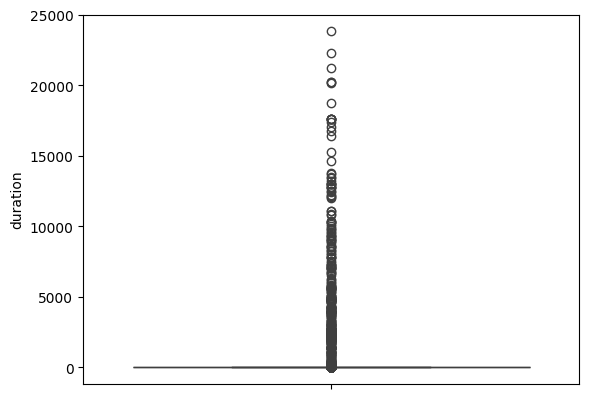

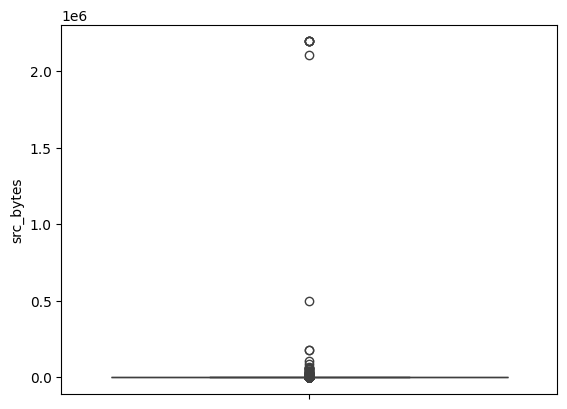

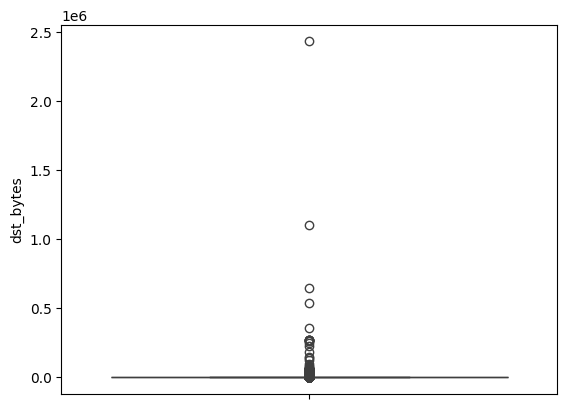

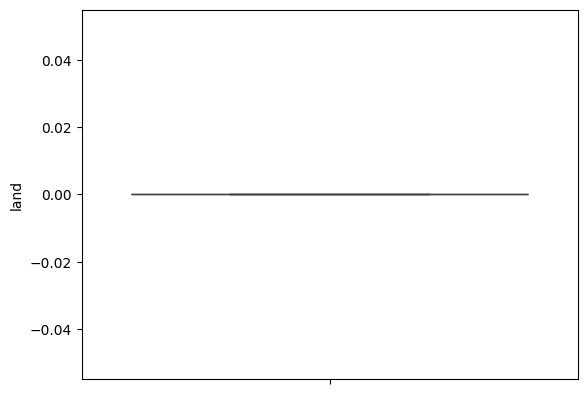

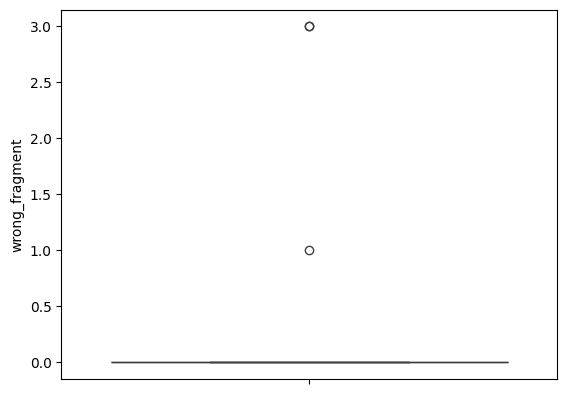

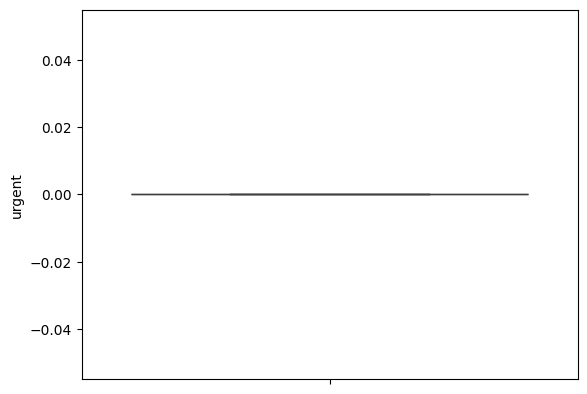

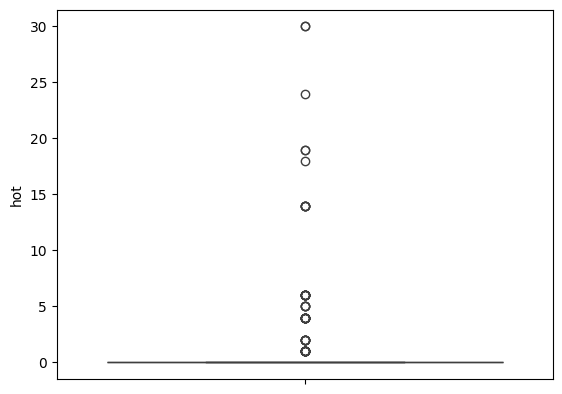

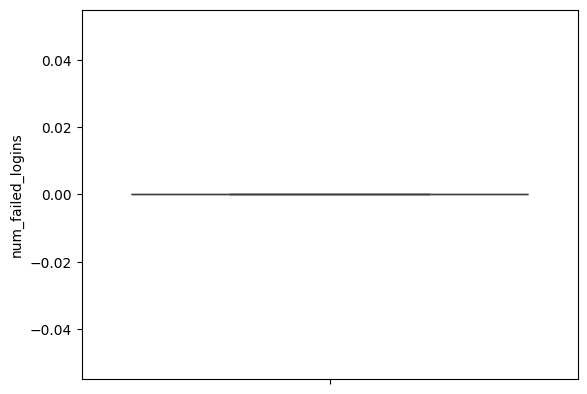

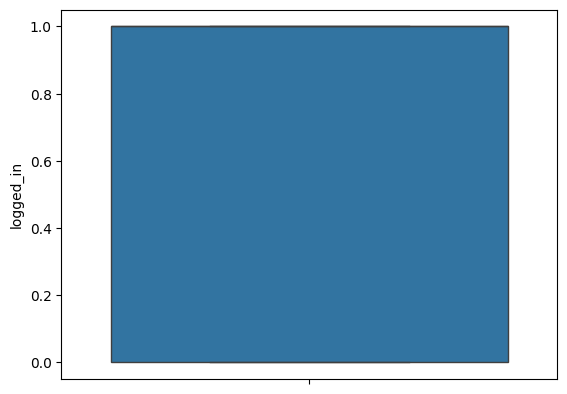

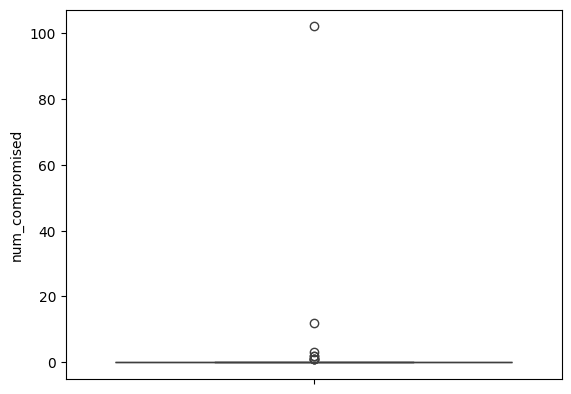

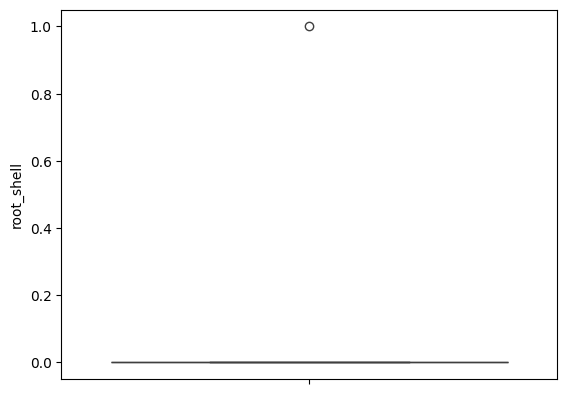

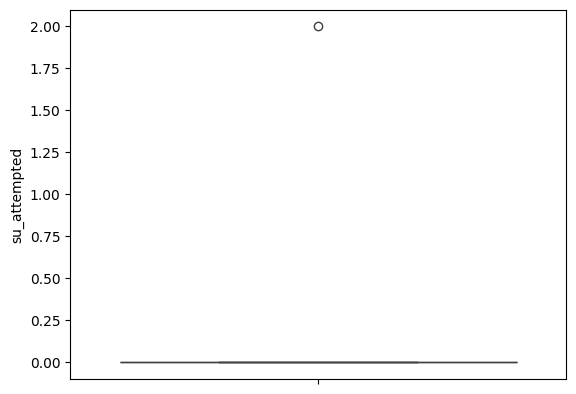

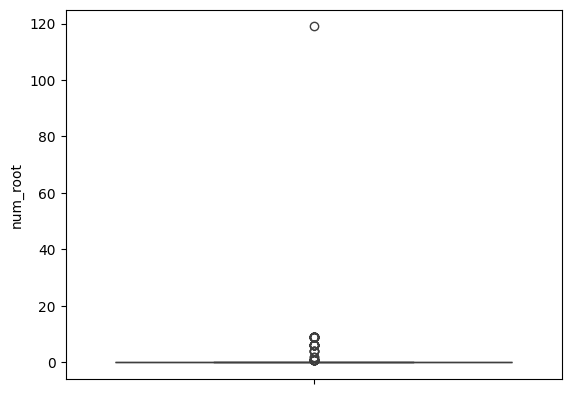

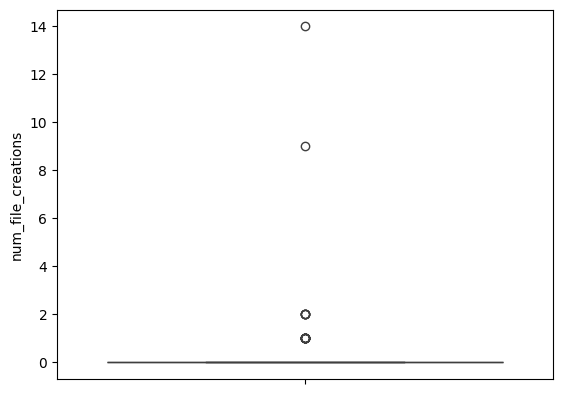

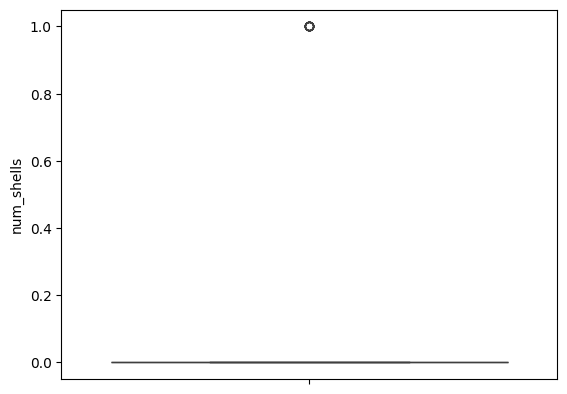

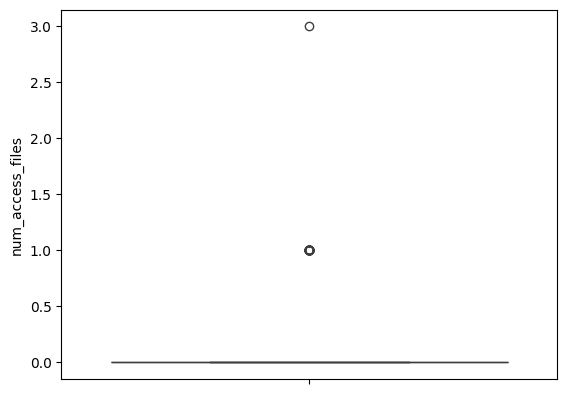

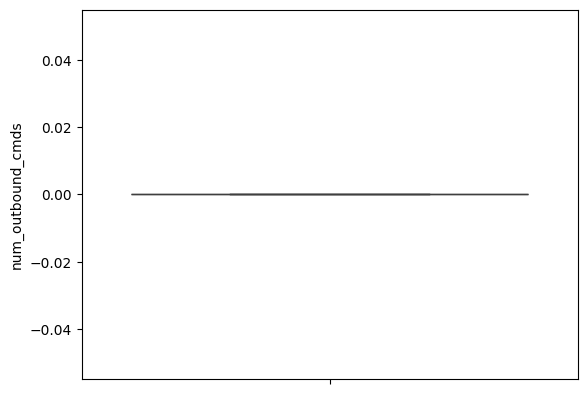

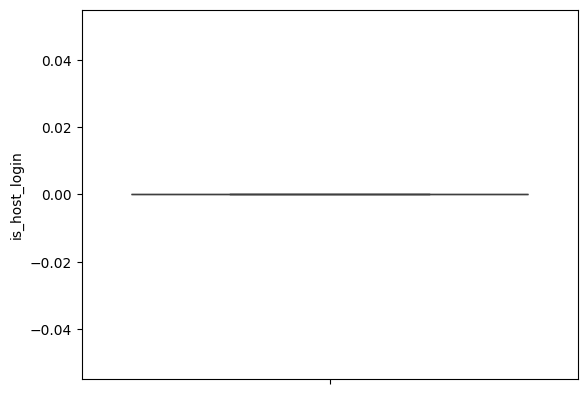

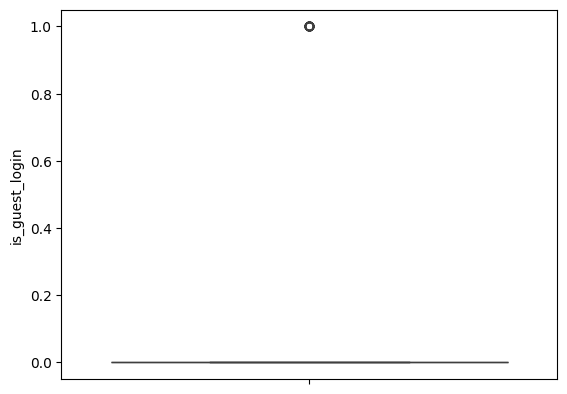

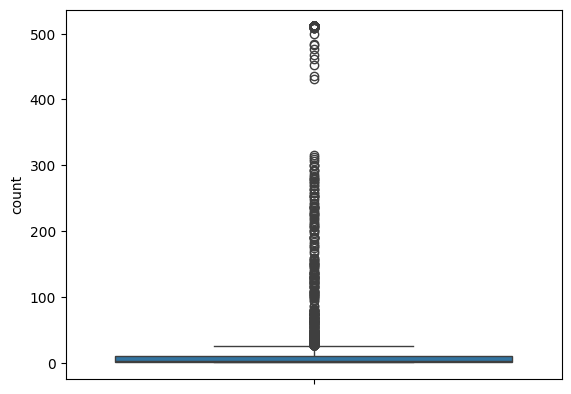

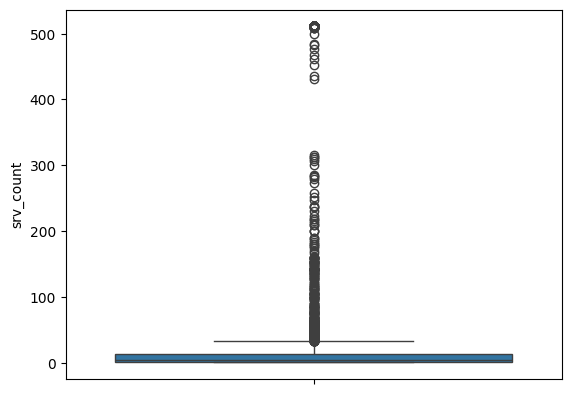

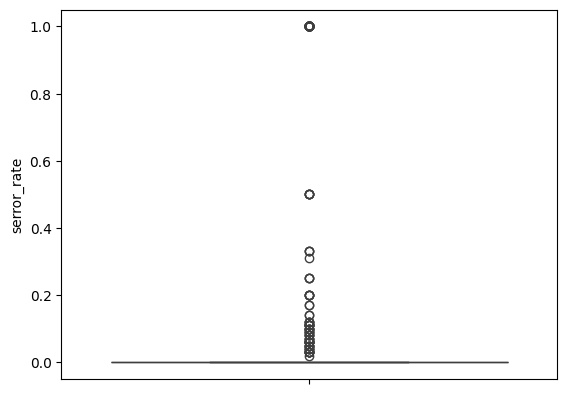

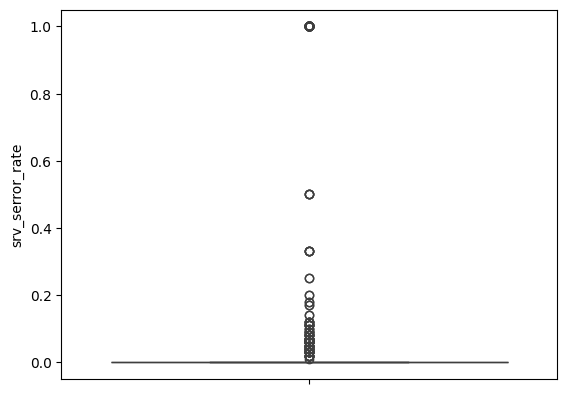

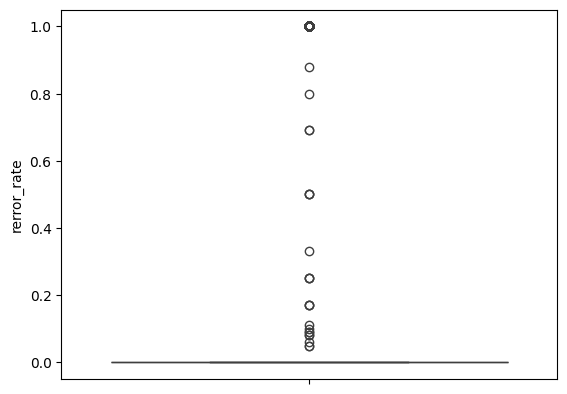

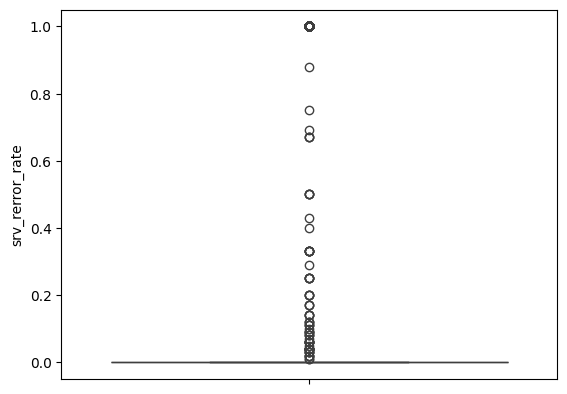

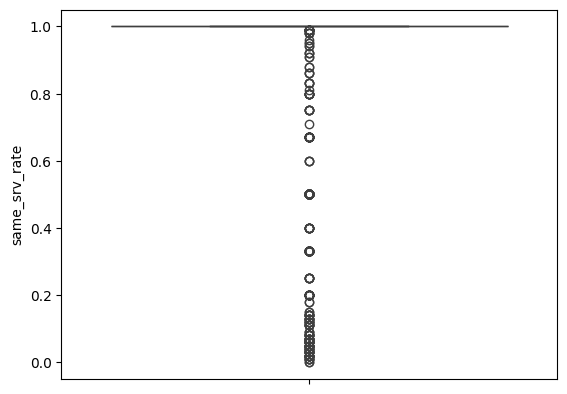

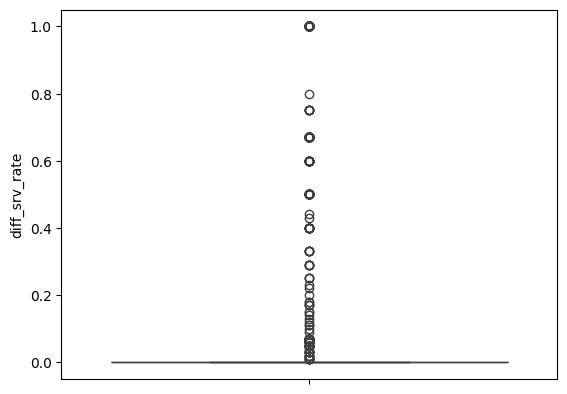

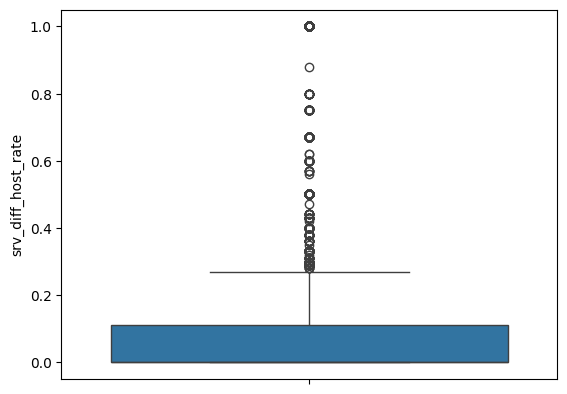

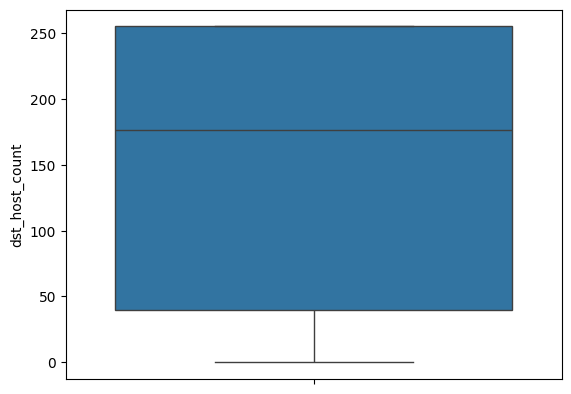

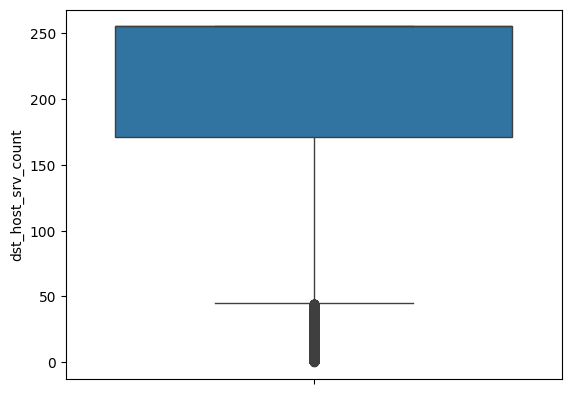

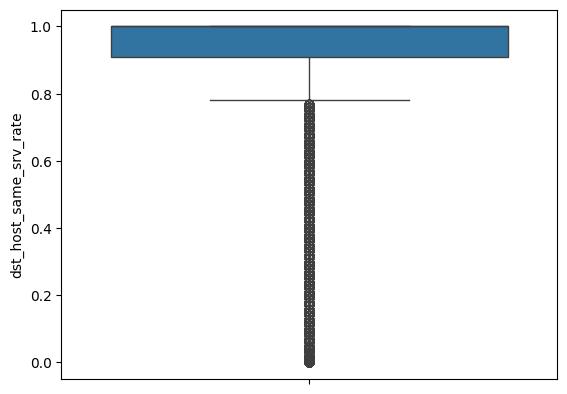

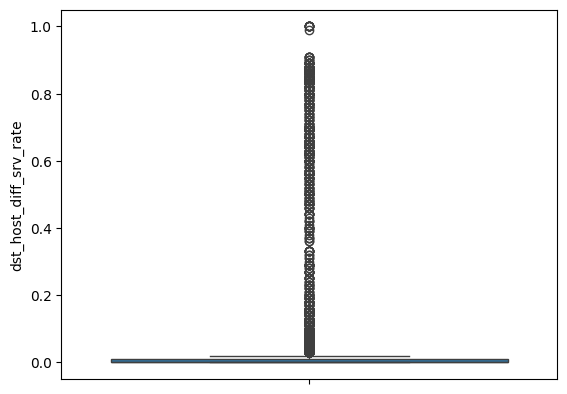

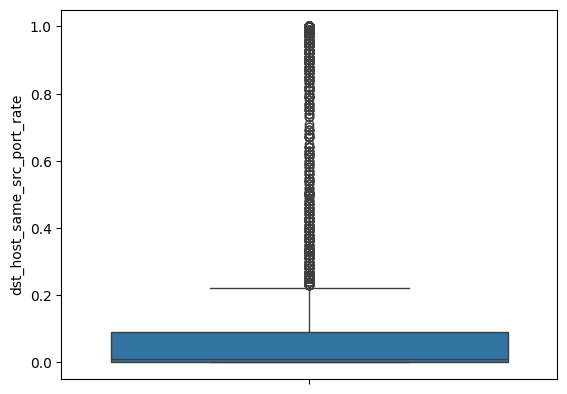

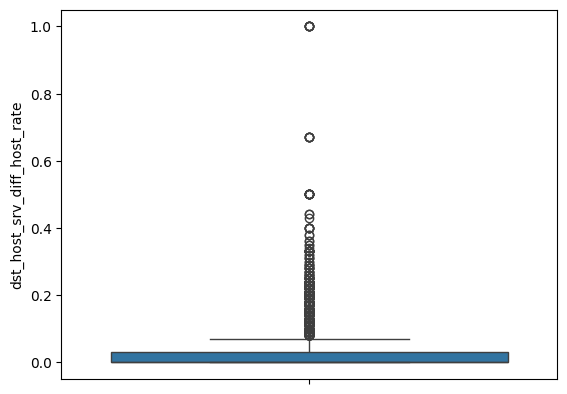

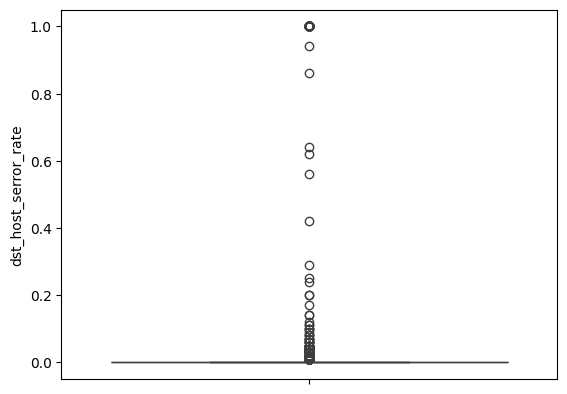

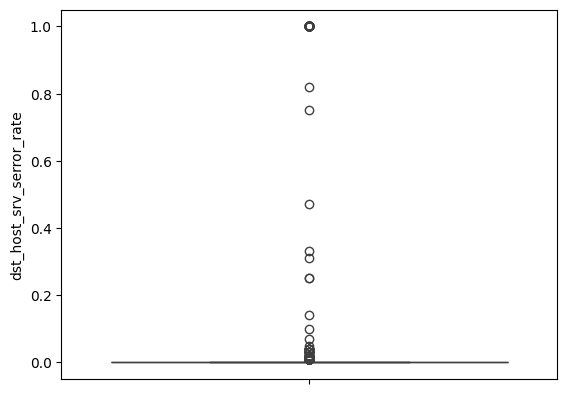

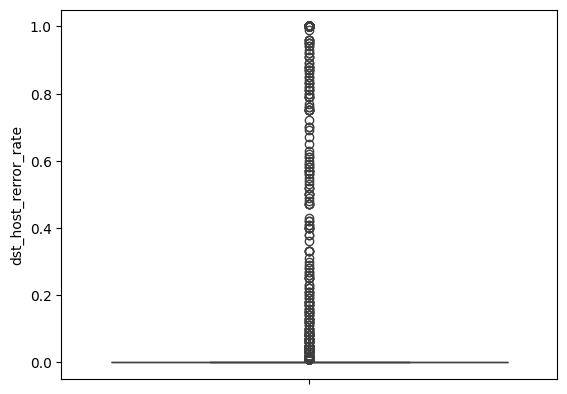

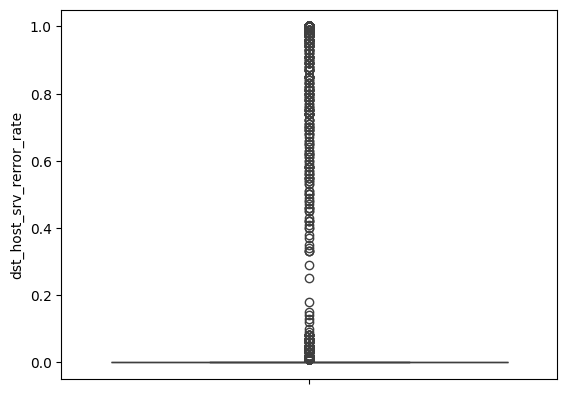

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in X.select_dtypes(include=[np.float64]).columns:
  sns.boxplot(X[col])
  plt.show()

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10065 entries, 26890 to 95188
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     10065 non-null  float64
 1   protocol_type                10065 non-null  object 
 2   service                      10065 non-null  object 
 3   flag                         10065 non-null  object 
 4   src_bytes                    10065 non-null  float64
 5   dst_bytes                    10065 non-null  float64
 6   land                         10065 non-null  float64
 7   wrong_fragment               10065 non-null  float64
 8   urgent                       10065 non-null  float64
 9   hot                          10065 non-null  float64
 10  num_failed_logins            10065 non-null  float64
 11  logged_in                    10065 non-null  float64
 12  num_compromised              10065 non-null  float64
 13  root_shell       

In [ ]:
CategoricalPipeline = make_pipeline(OrdinalEncoder())
RobustNumericalPipeline = make_pipeline(RobustScaler())
StandardNumericalPipeline = make_pipeline(StandardScaler())
MinMaxNumericalPipeline = make_pipeline(MinMaxScaler())

In [ ]:
CatColumns = X.select_dtypes(exclude=[np.float64]).columns
NumColumns = X.select_dtypes(include=[np.float64]).columns

In [ ]:
RobustColumnTrans = ColumnTransformer([('Categorical',CategoricalPipeline,CatColumns),
                                 ('Numerical',RobustNumericalPipeline,NumColumns)
                                  ])

StandardColumnTrans = ColumnTransformer([('Categorical',CategoricalPipeline,CatColumns),
                                 ('Numerical',StandardNumericalPipeline,NumColumns)
                                  ])

MinMaxColumnTrans = ColumnTransformer([('Categorical',CategoricalPipeline,CatColumns),
                                 ('Numerical',MinMaxNumericalPipeline,NumColumns)
                                  ])

In [ ]:
RobustX = RobustColumnTrans.fit_transform(X)

StandardX = StandardColumnTrans.fit_transform(X)

MinMaxX = MinMaxColumnTrans.fit_transform(X)

y_temp = np.where((y==0)|(y==1), y^1, y)

dic = {"MinMaxScaling":MinMaxX,"StandardScaling":StandardX,"RobustScaler":RobustX}

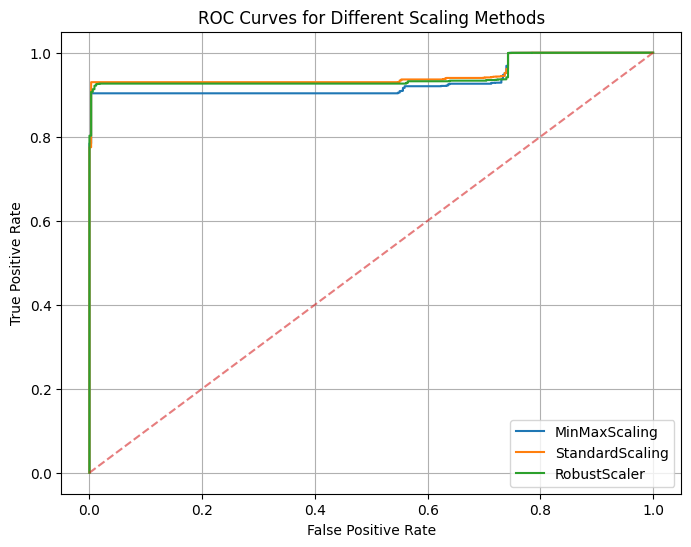

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    IsolationForestEstimator = IsolationForest()

    lof_preds = IsolationForestEstimator.fit_predict(CT)

    IF_y_Scores = IsolationForestEstimator.decision_function(CT)

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


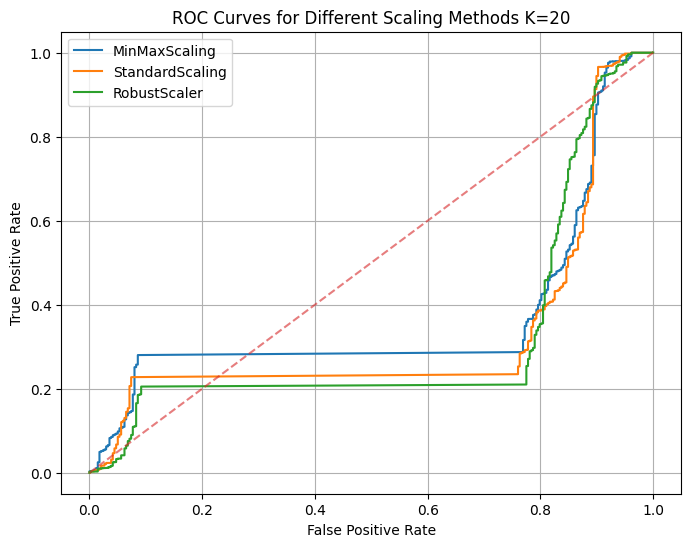

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=20)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=20")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


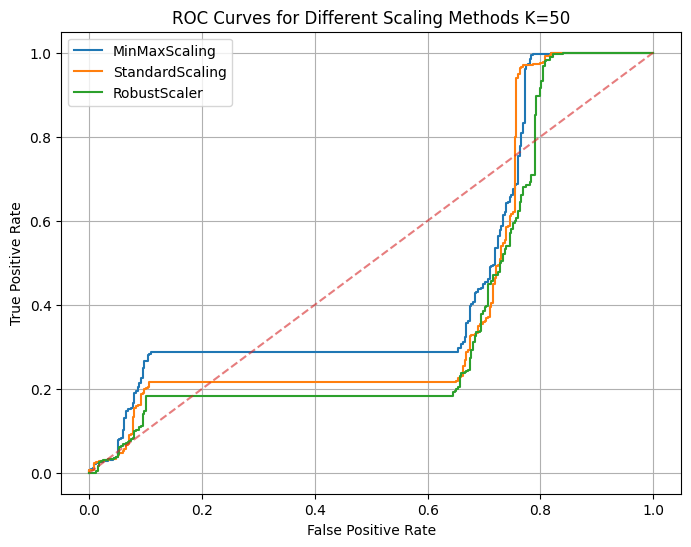

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=50)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=50")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


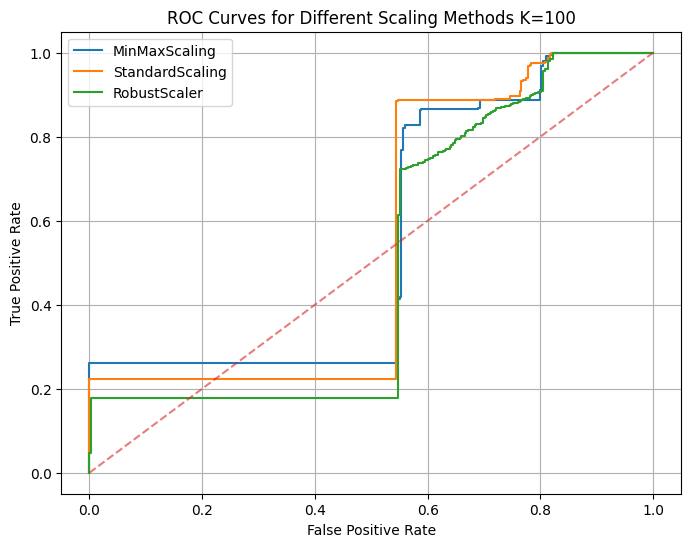

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=100)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=100")
plt.legend()
plt.grid(True)
plt.show()

### Forest covertypes dataset

The `covtype_dataset` is a multiclass dataset where the target is the
dominant species of tree in a given patch of forest. It contains 54 features,
some of which ("Wilderness_Area" and "Soil_Type") are already binary encoded.
Though originally meant as a classification task, one can regard inliers as
samples encoded with label 2 and outliers as those with label 4.



In [ ]:
from sklearn.datasets import fetch_covtype

X, y = fetch_covtype(return_X_y=True, as_frame=True)
s = (y == 2) + (y == 4)
X = X.loc[s]
y = y.loc[s]
y = (y != 2).astype(np.int32)

X, _, y, _ = train_test_split(X, y, train_size=0.05, stratify=y, random_state=42)
X_forestcover = X  # save X for later use

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

14302 datapoints with 137 anomalies (0.96%)


In [ ]:
for column in X.columns:
  temp=pd.to_numeric(X.loc[:,column], errors='coerce')
  if temp.isnull().sum() == 0:
    X[column]=temp.astype('float')

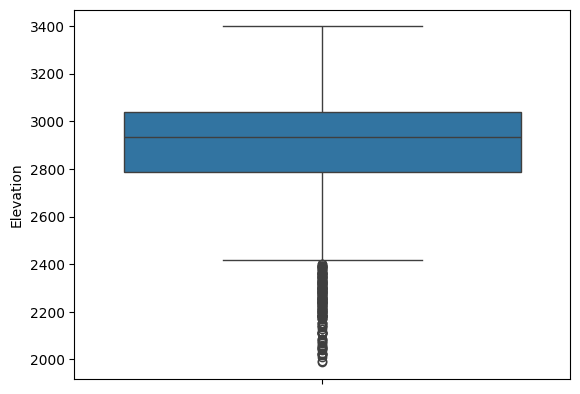

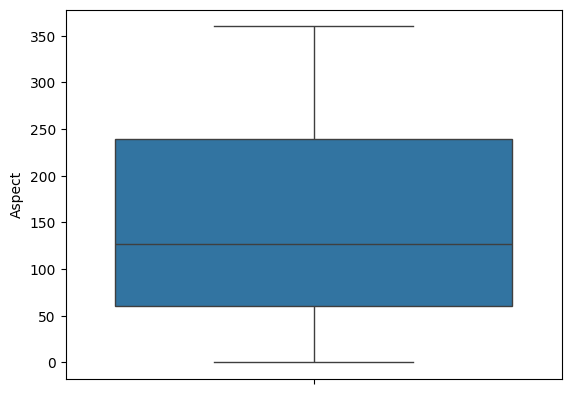

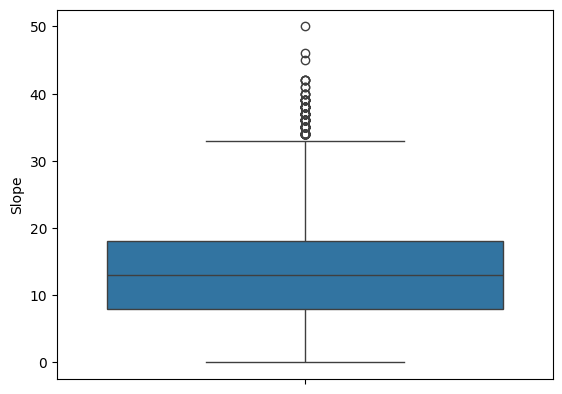

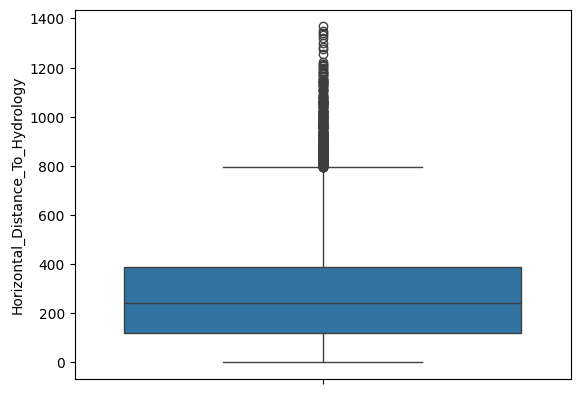

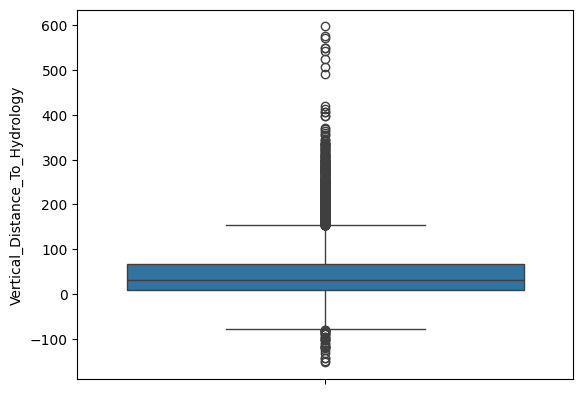

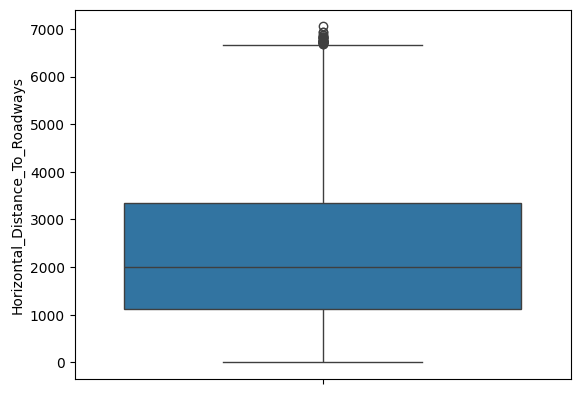

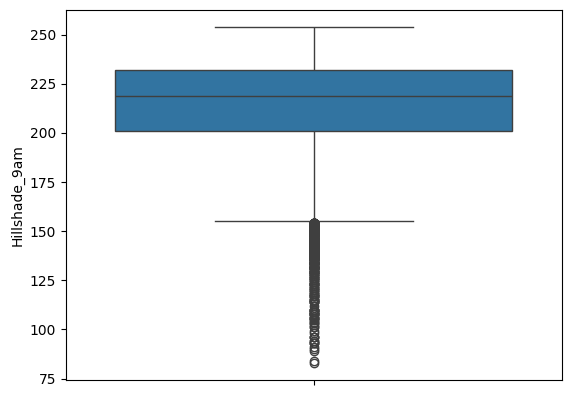

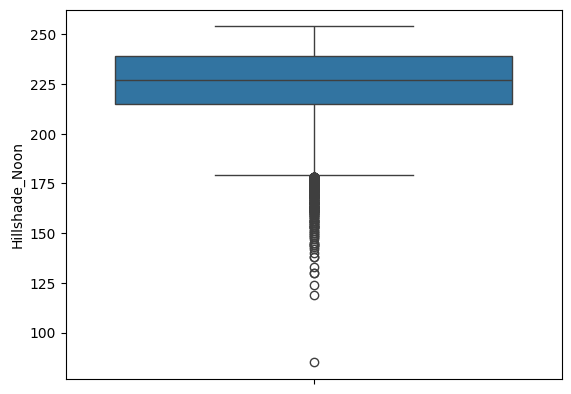

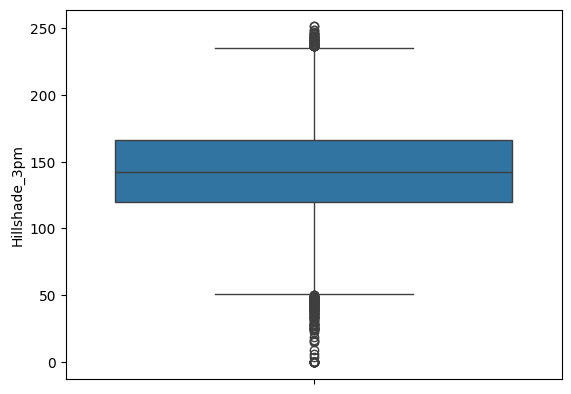

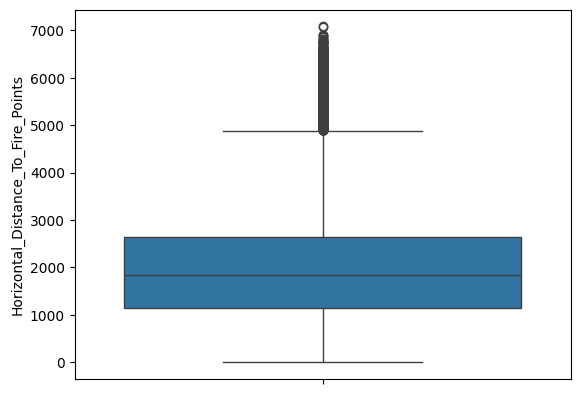

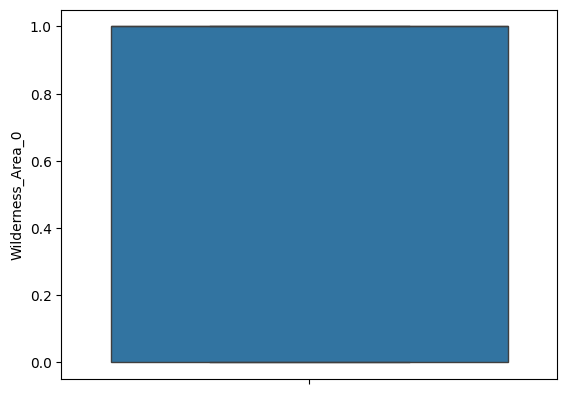

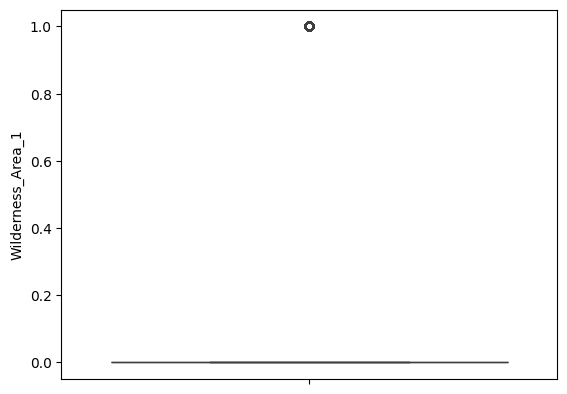

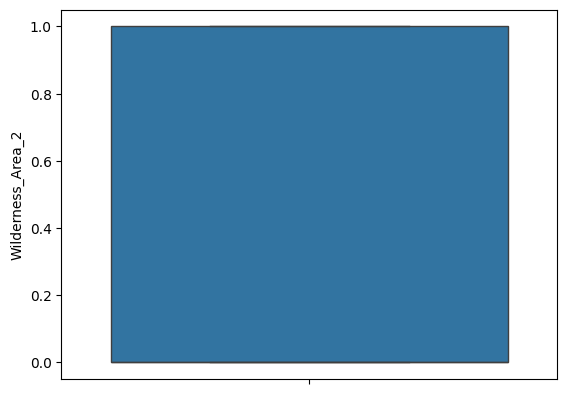

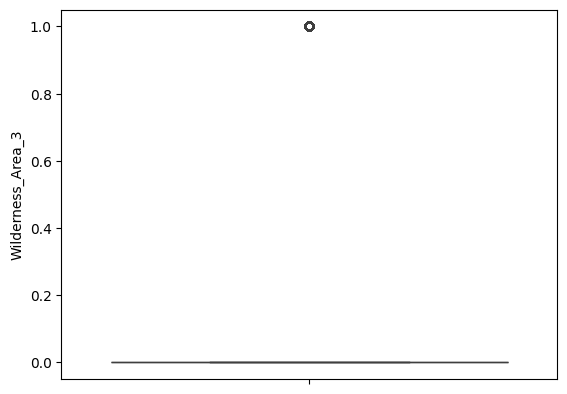

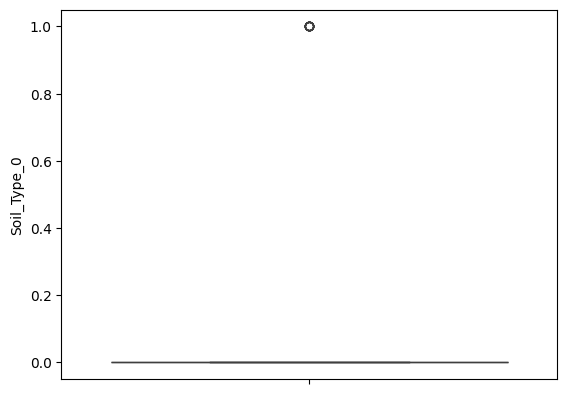

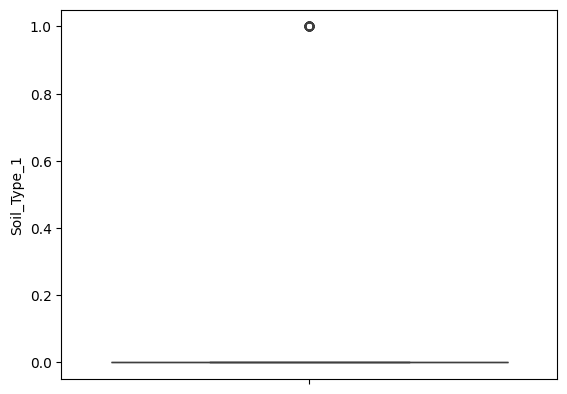

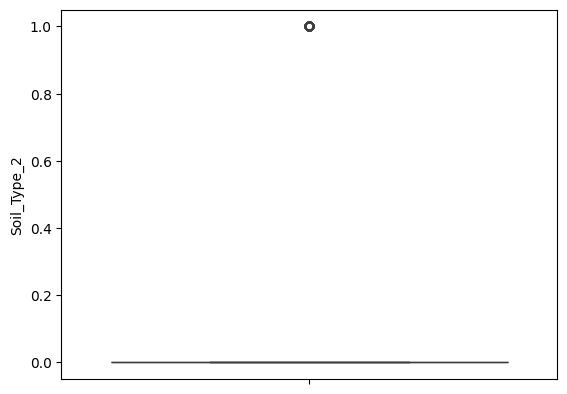

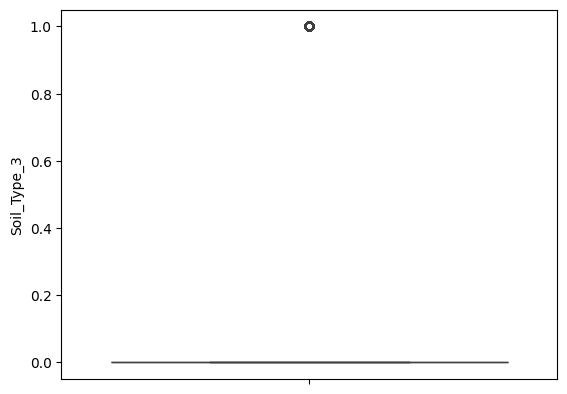

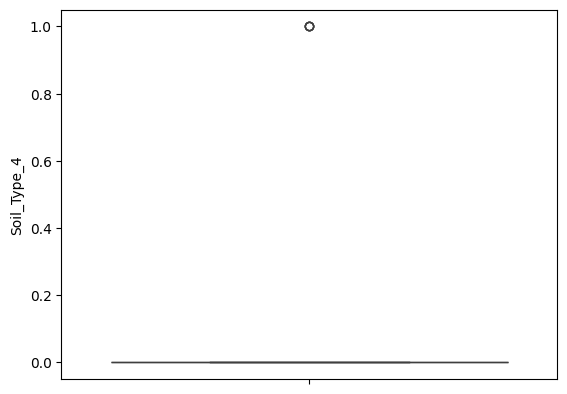

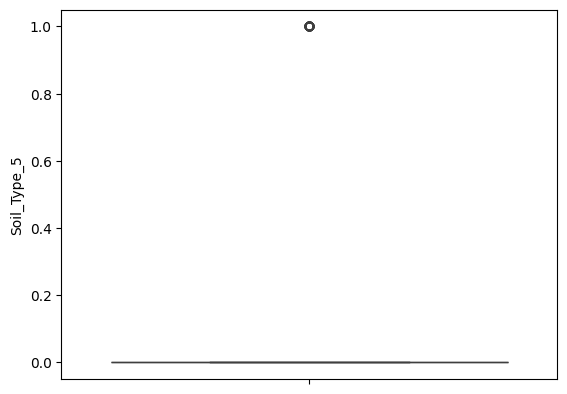

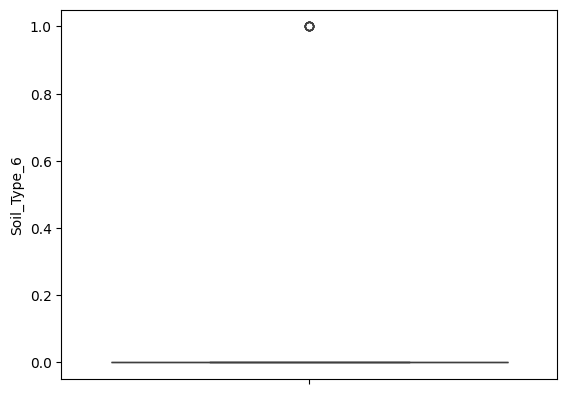

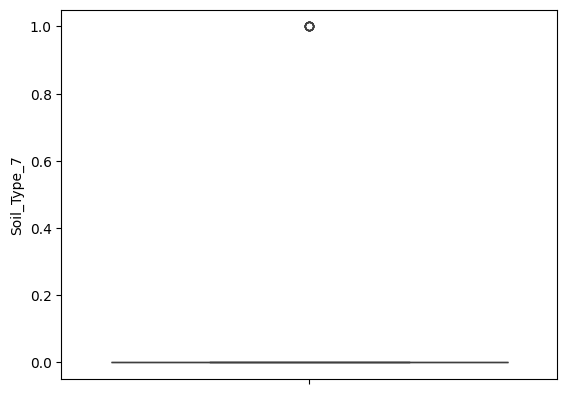

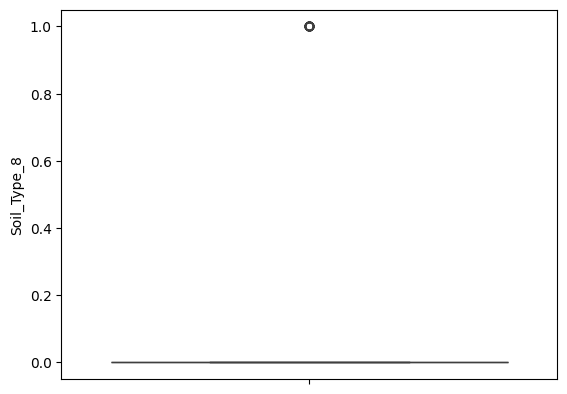

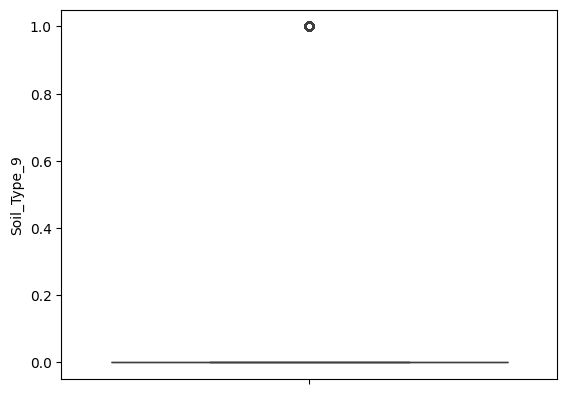

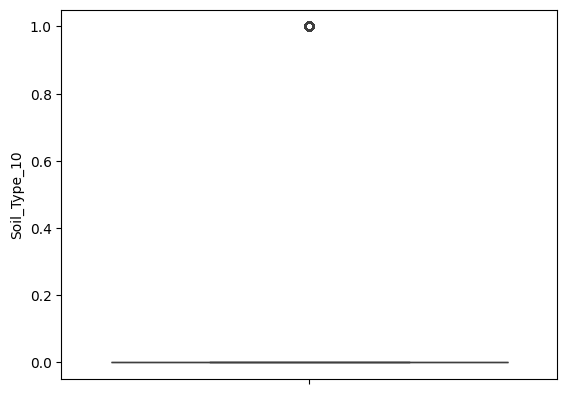

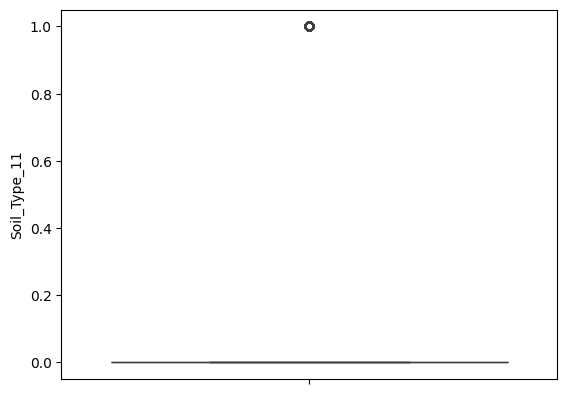

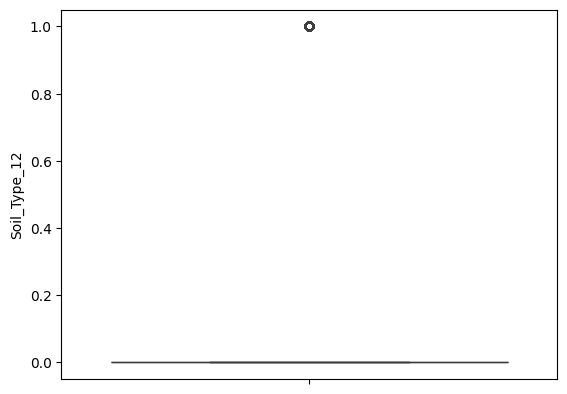

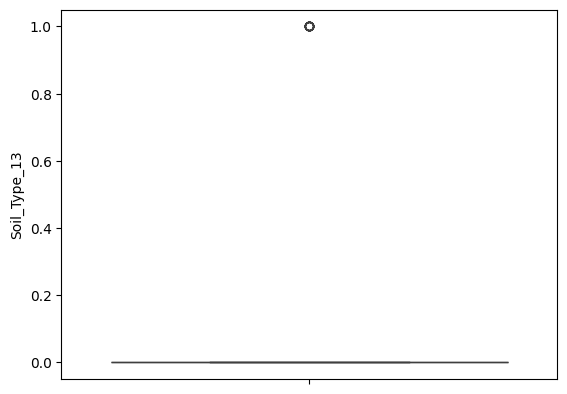

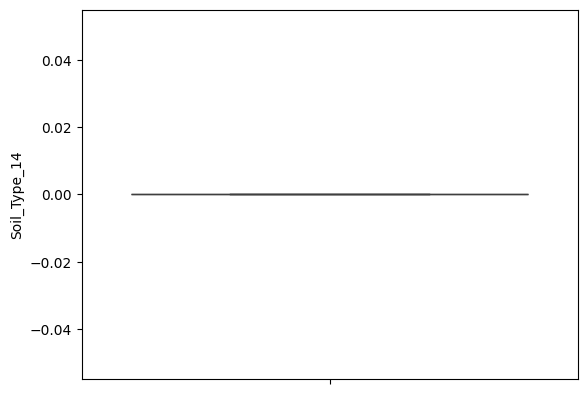

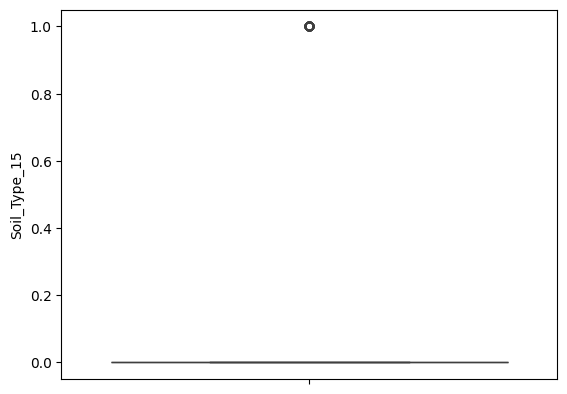

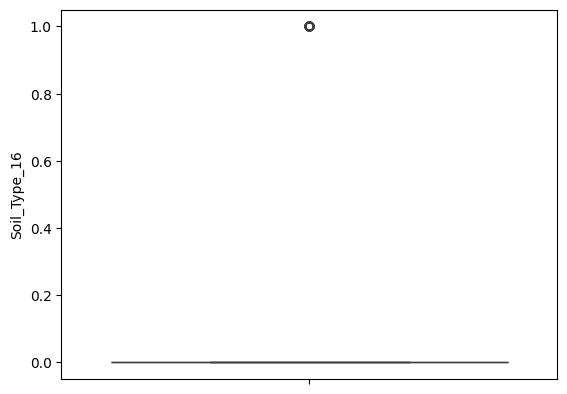

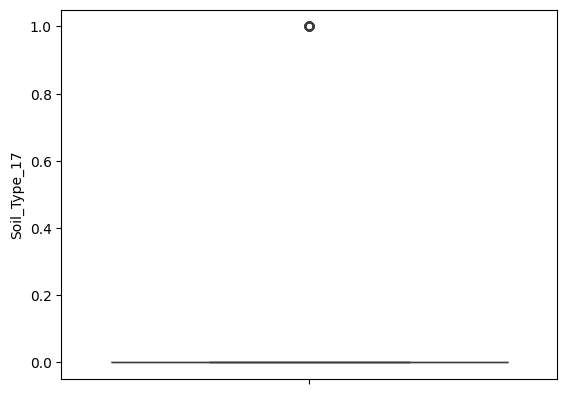

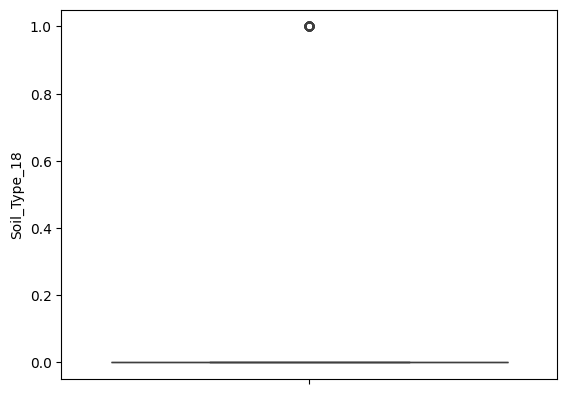

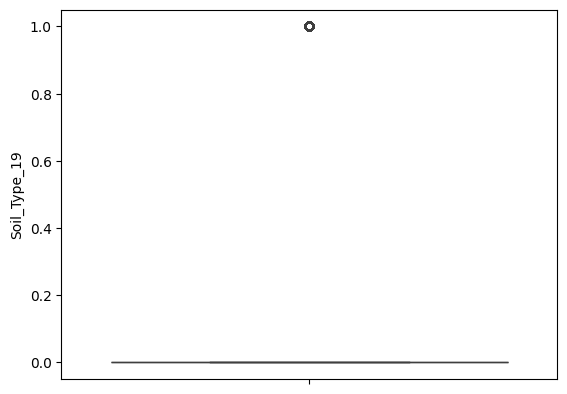

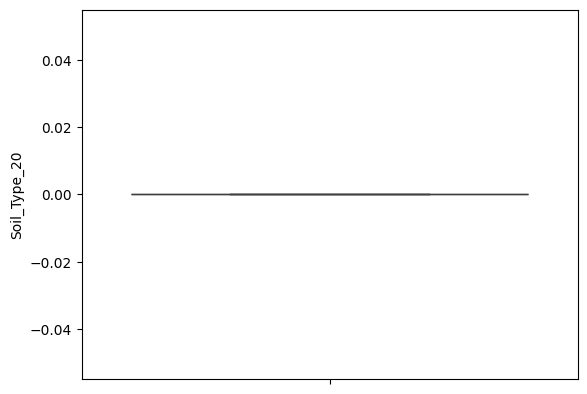

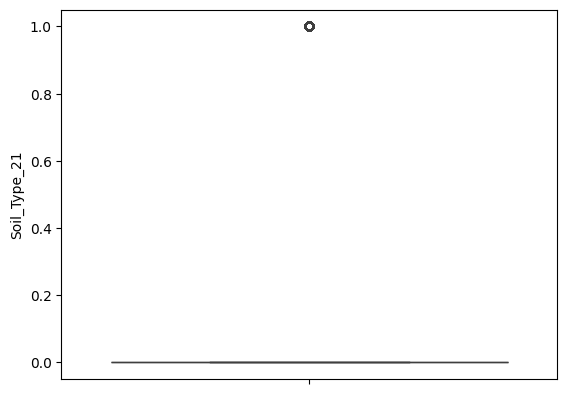

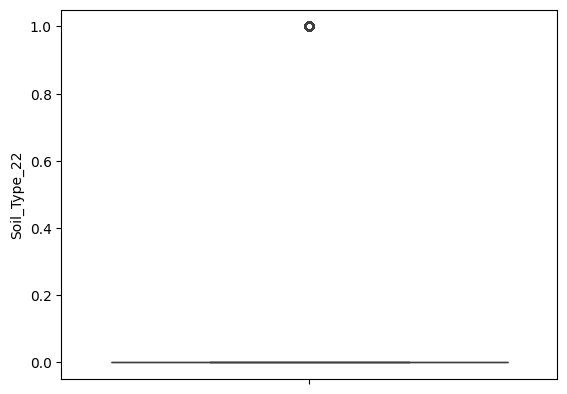

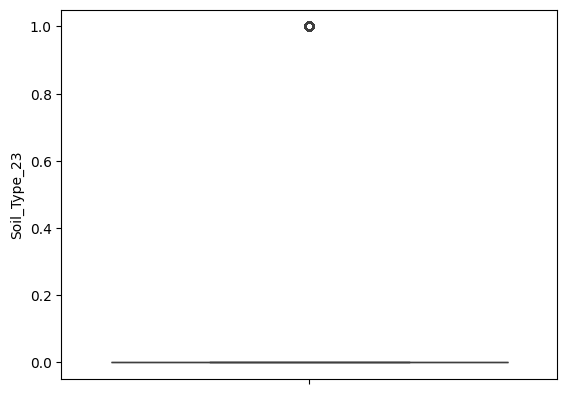

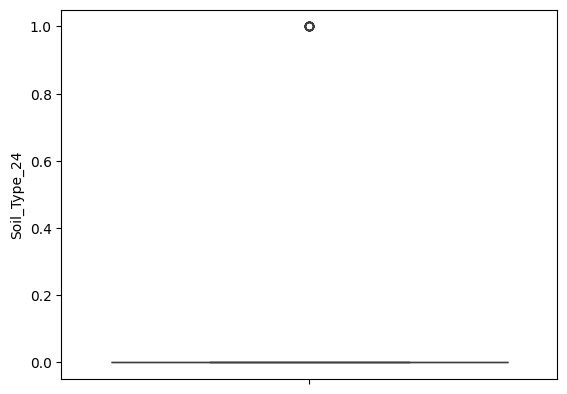

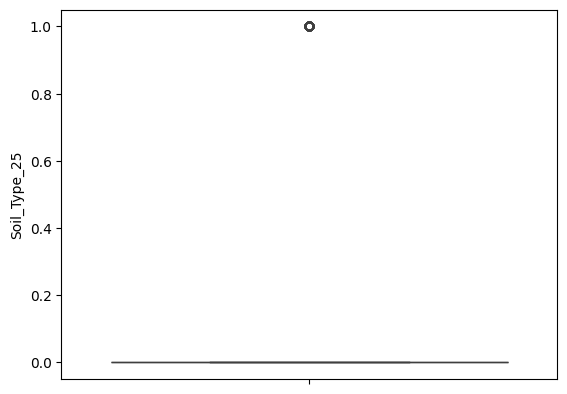

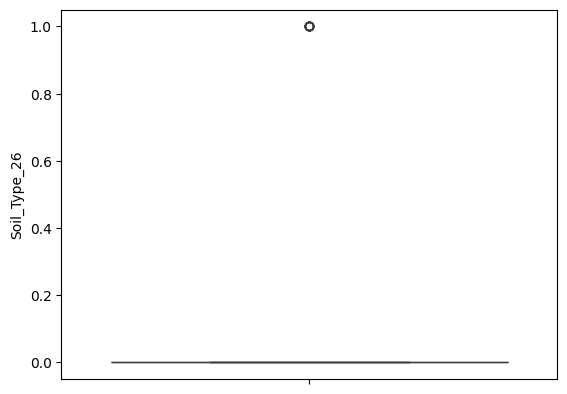

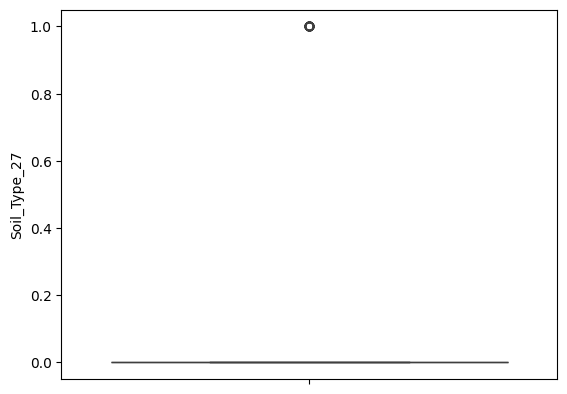

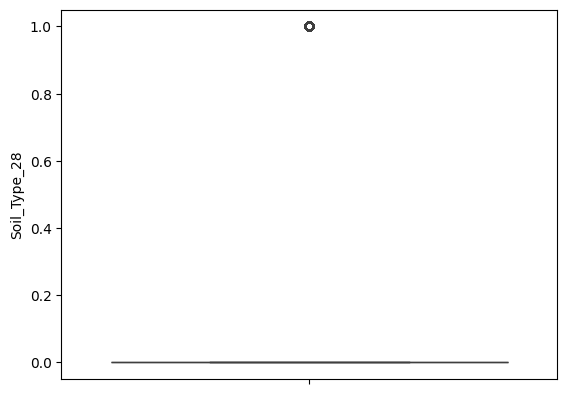

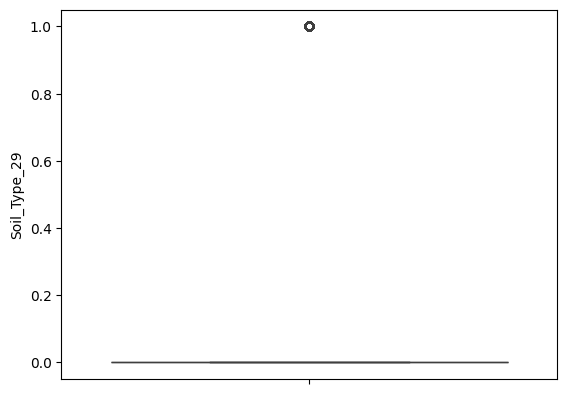

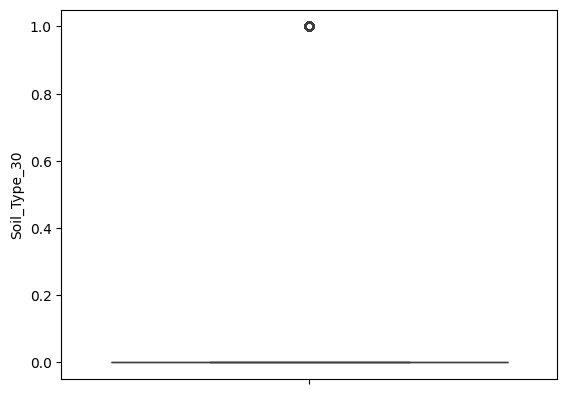

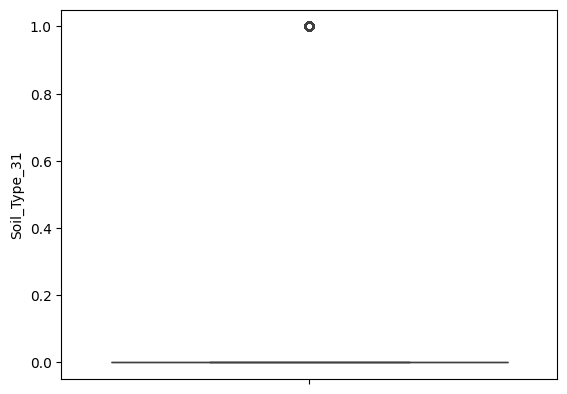

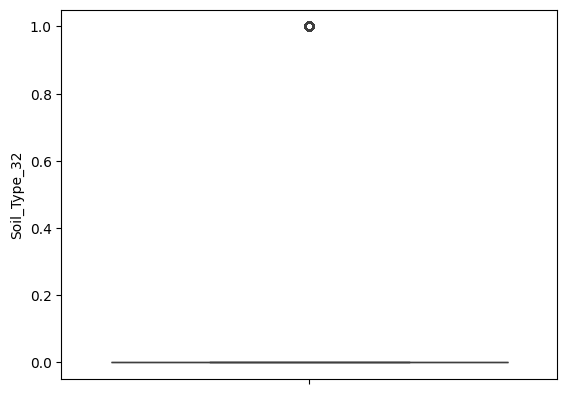

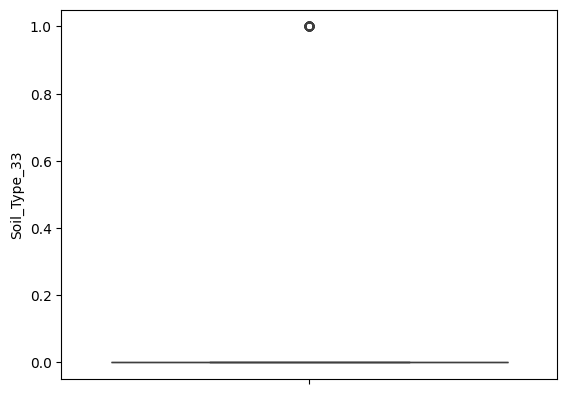

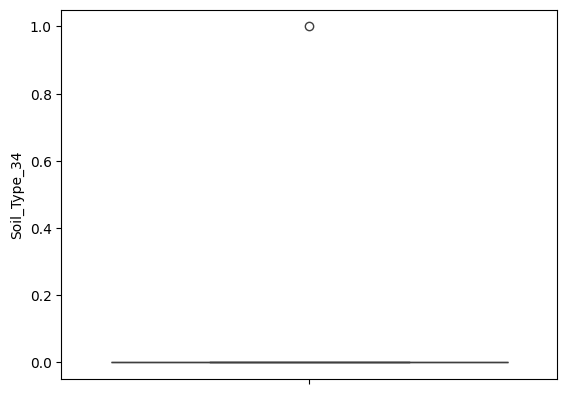

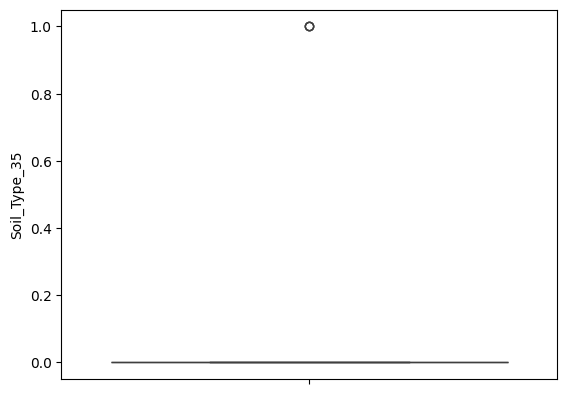

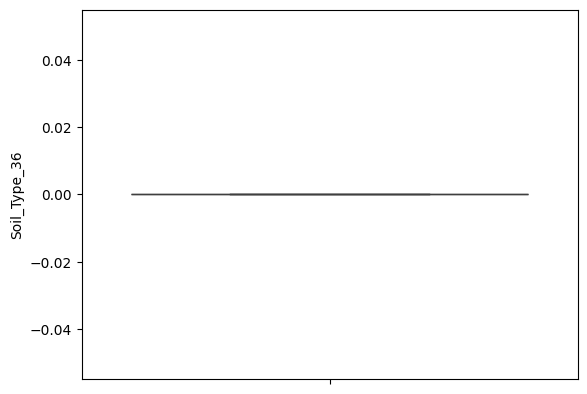

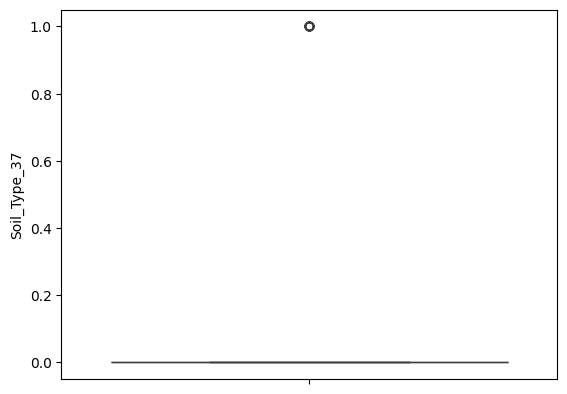

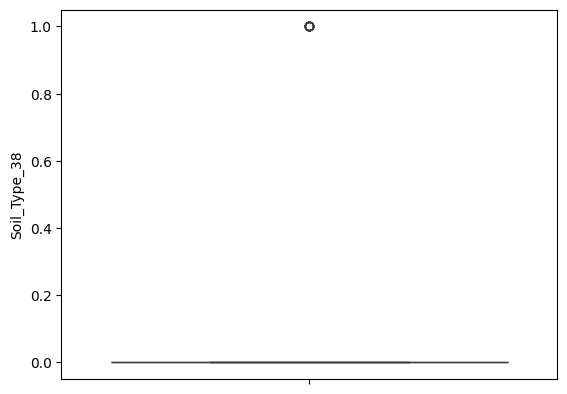

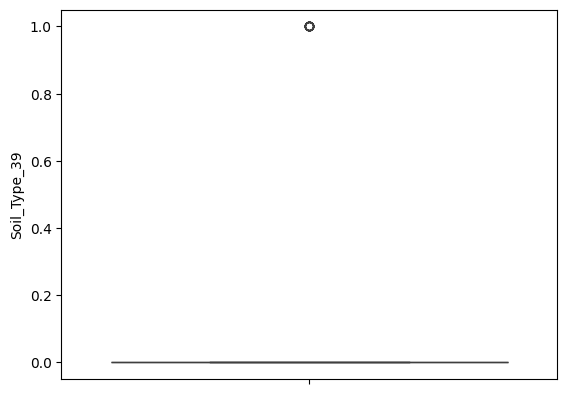

In [ ]:
for col in X.select_dtypes(include=[np.float64]).columns:
  sns.boxplot(X[col])
  plt.show()

In [ ]:
CatColumns = X.select_dtypes(exclude=[np.float64]).columns
NumColumns = X.select_dtypes(include=[np.float64]).columns

RobustColumnTrans = ColumnTransformer([('Categorical',CategoricalPipeline,CatColumns),
                                 ('Numerical',RobustNumericalPipeline,NumColumns)
                                  ])

StandardColumnTrans = ColumnTransformer([('Categorical',CategoricalPipeline,CatColumns),
                                 ('Numerical',StandardNumericalPipeline,NumColumns)
                                  ])

MinMaxColumnTrans = ColumnTransformer([('Categorical',CategoricalPipeline,CatColumns),
                                 ('Numerical',MinMaxNumericalPipeline,NumColumns)
                                  ])

In [ ]:
RobustX = RobustColumnTrans.fit_transform(X)

StandardX = StandardColumnTrans.fit_transform(X)

MinMaxX = MinMaxColumnTrans.fit_transform(X)

y_temp = np.where((y==0)|(y==1), y^1, y)

dic = {"MinMaxScaling":MinMaxX,"StandardScaling":StandardX,"RobustScaler":RobustX}

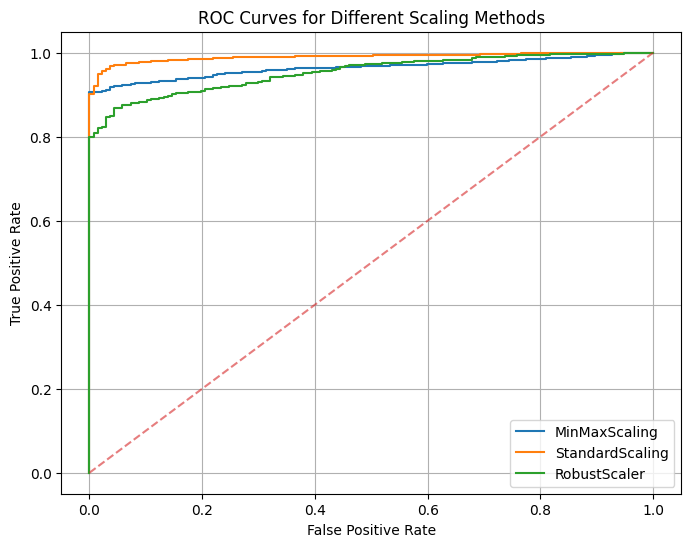

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    IsolationForestEstimator = IsolationForest()

    lof_preds = IsolationForestEstimator.fit_predict(CT)

    IF_y_Scores = IsolationForestEstimator.decision_function(CT)

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods")
plt.legend()
plt.grid(True)
plt.show()

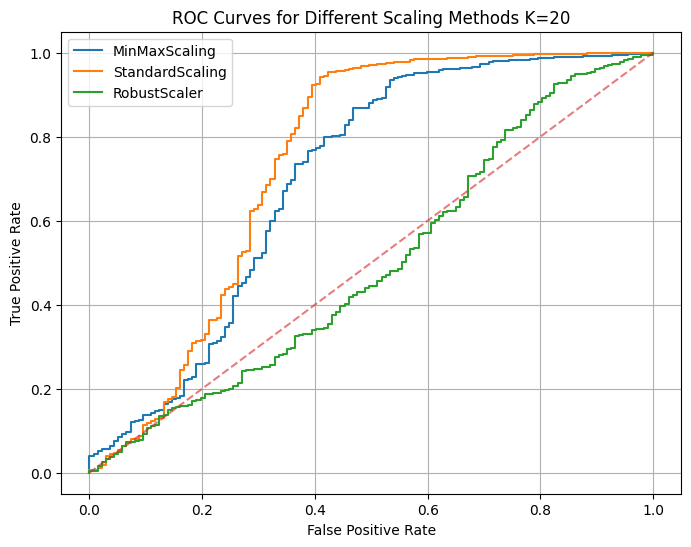

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=20)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=20")
plt.legend()
plt.grid(True)
plt.show()

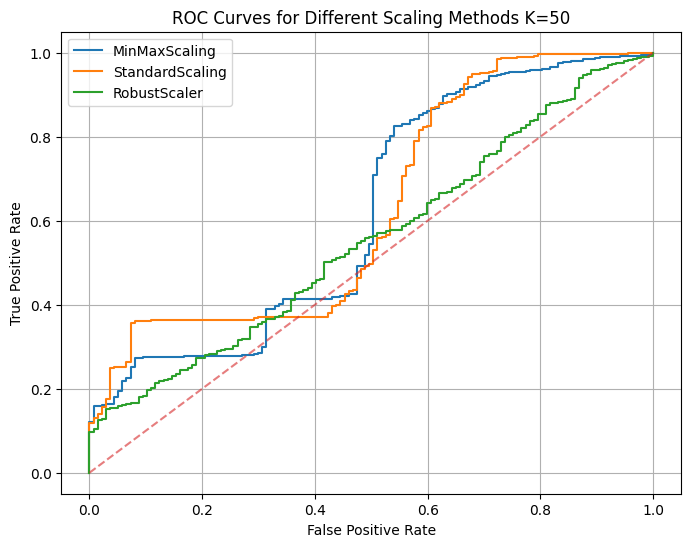

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=50)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=50")
plt.legend()
plt.grid(True)
plt.show()

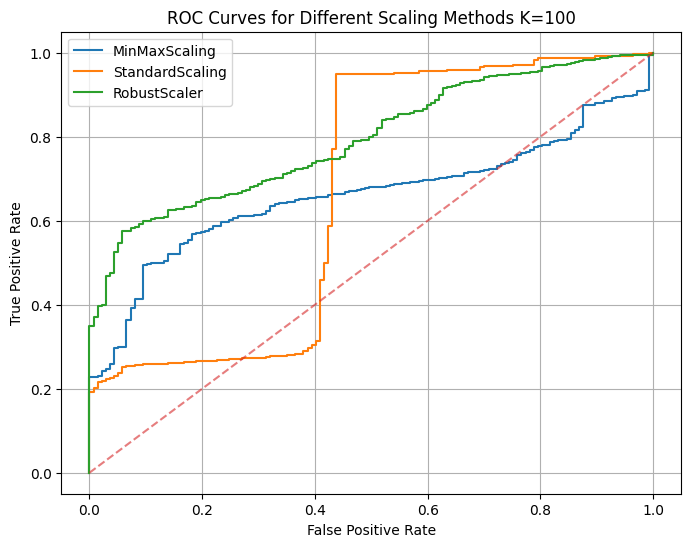

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=100)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=100")
plt.legend()
plt.grid(True)
plt.show()

### Ames Housing dataset

The [Ames housing dataset](http://www.openml.org/d/43926) is originally a
regression dataset where the target are sales prices of houses in Ames, Iowa.
Here we convert it into an outlier detection problem by regarding houses with
price over 70 USD/sqft. To make the problem easier, we drop intermediate
prices between 40 and 70 USD/sqft.



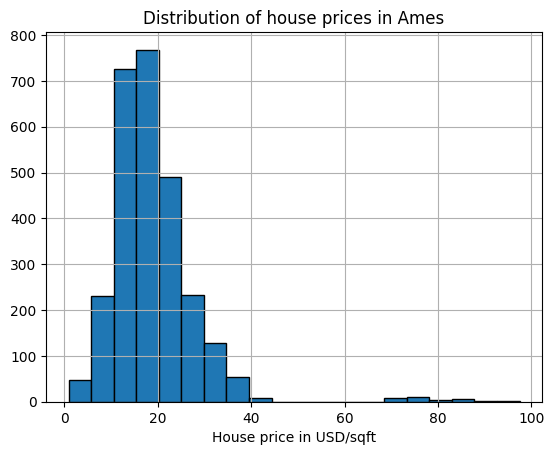

In [ ]:
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

X, y = fetch_openml(name="ames_housing", version=1, return_X_y=True, as_frame=True)
y = y.div(X["Lot_Area"])

# None values in pandas 1.5.1 were mapped to np.nan in pandas 2.0.1
X["Misc_Feature"] = X["Misc_Feature"].cat.add_categories("NoInfo").fillna("NoInfo")
X["Mas_Vnr_Type"] = X["Mas_Vnr_Type"].cat.add_categories("NoInfo").fillna("NoInfo")

X.drop(columns="Lot_Area", inplace=True)
mask = (y < 40) | (y > 70)
X = X.loc[mask]
y = y.loc[mask]
y.hist(bins=20, edgecolor="black")
plt.xlabel("House price in USD/sqft")
_ = plt.title("Distribution of house prices in Ames")

In [ ]:
y = (y > 70).astype(np.int32)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

2714 datapoints with 30 anomalies (1.11%)


In [ ]:
for column in X.columns:
  temp=pd.to_numeric(X.loc[:,column], errors='coerce')
  if temp.isnull().sum() == 0:
    X[column]=temp.astype('float')

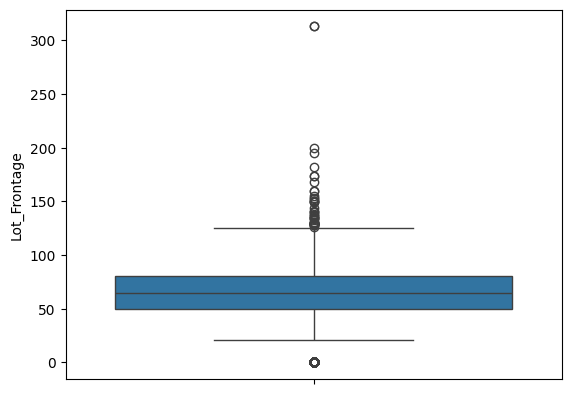

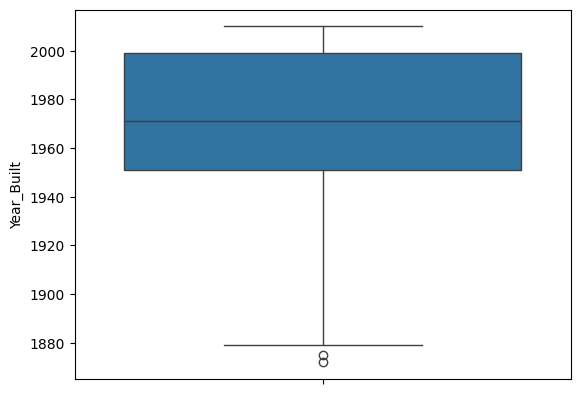

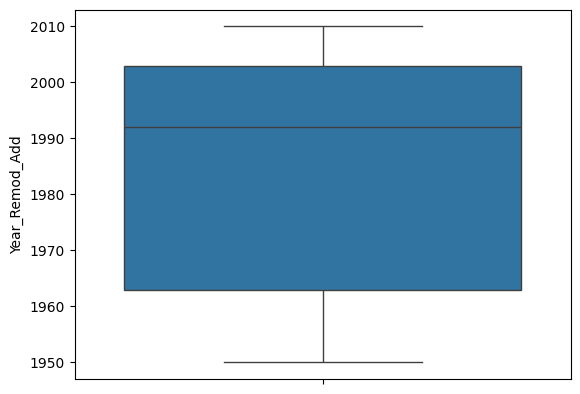

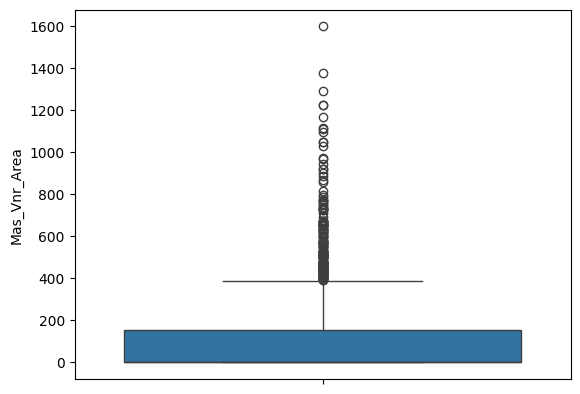

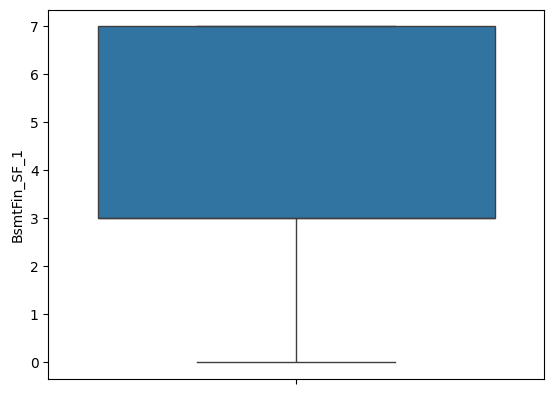

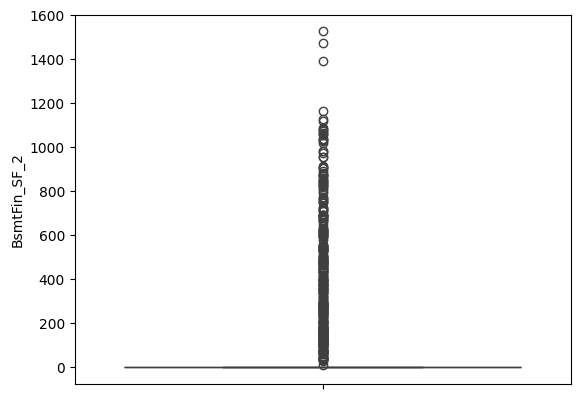

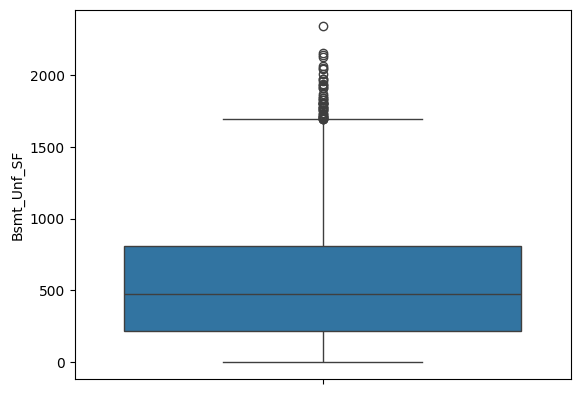

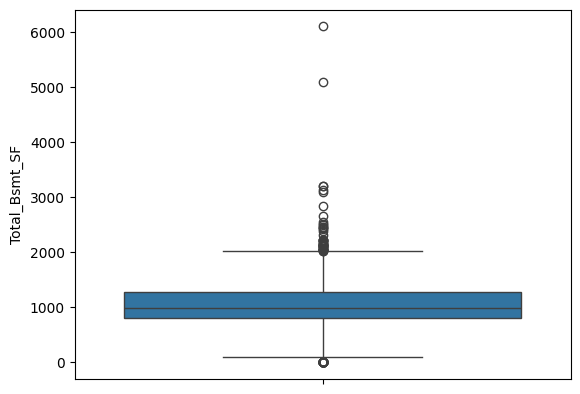

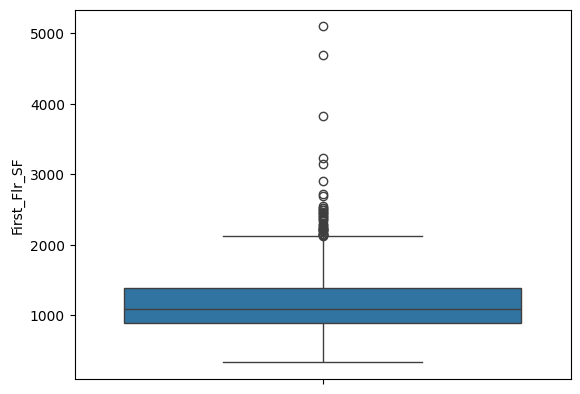

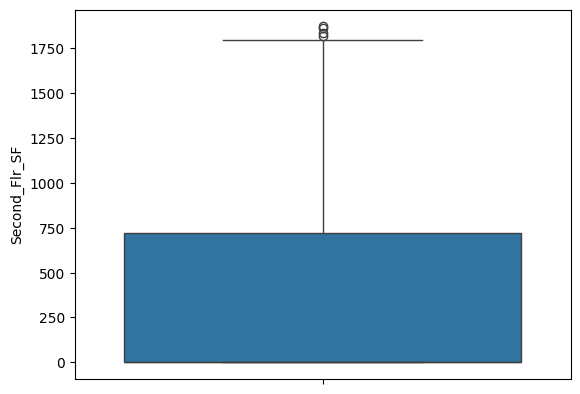

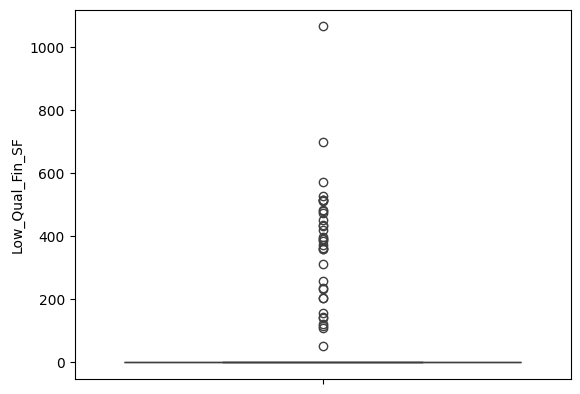

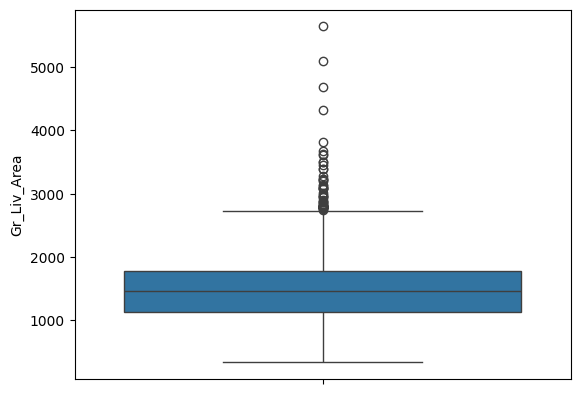

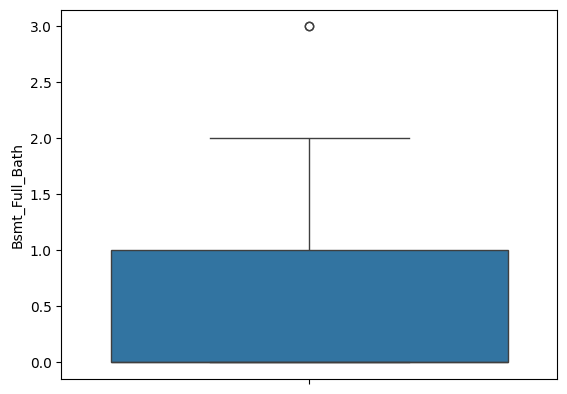

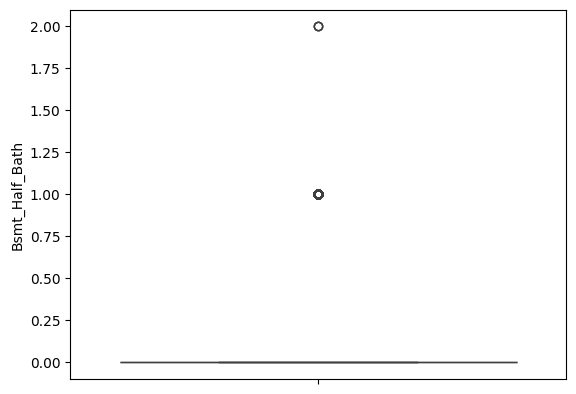

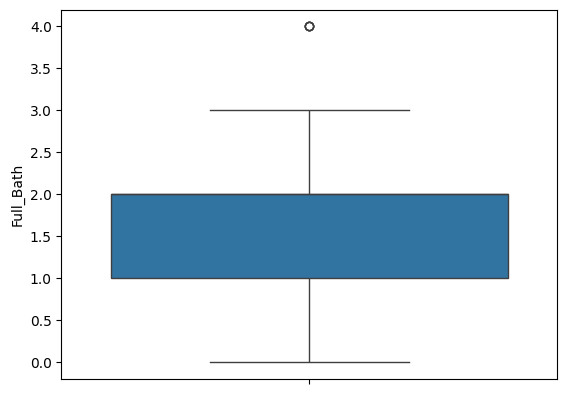

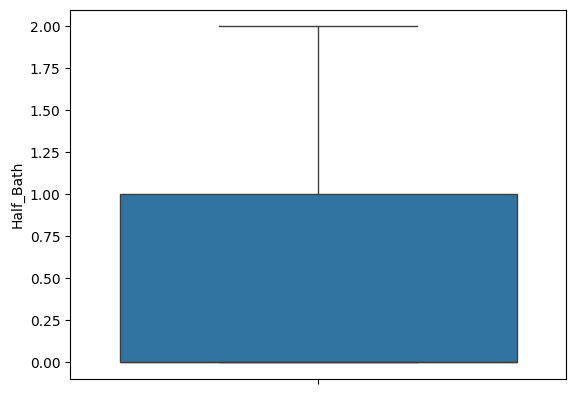

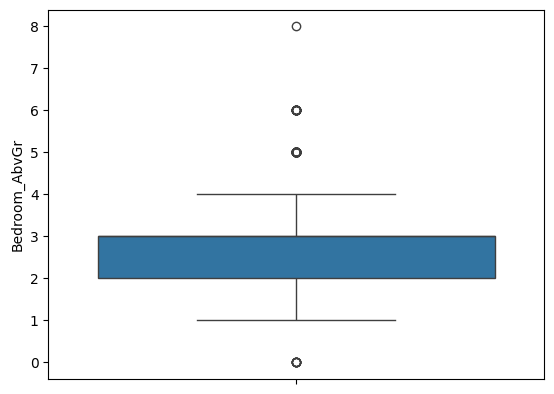

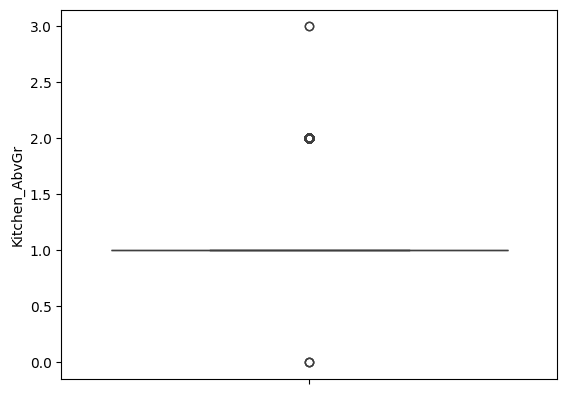

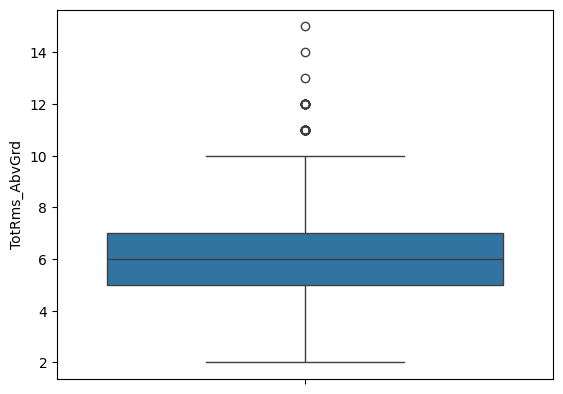

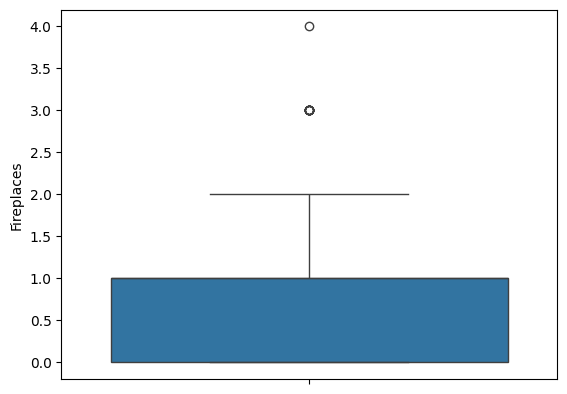

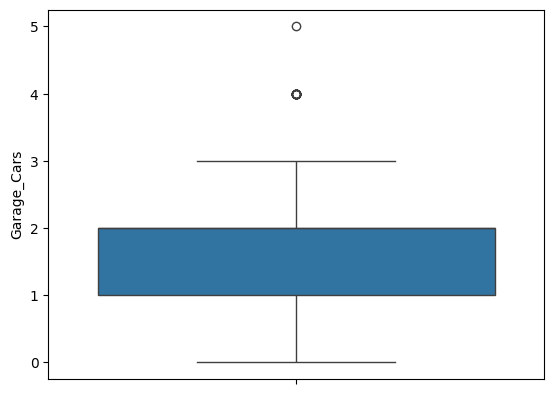

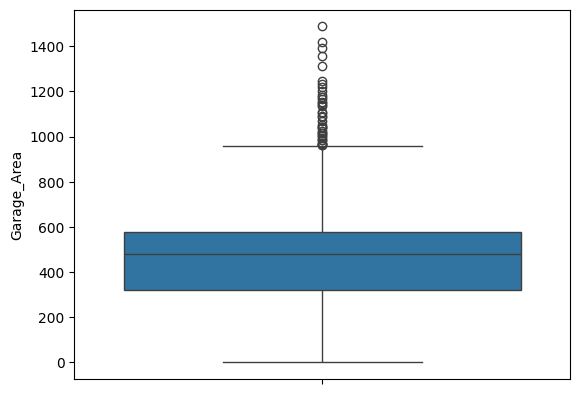

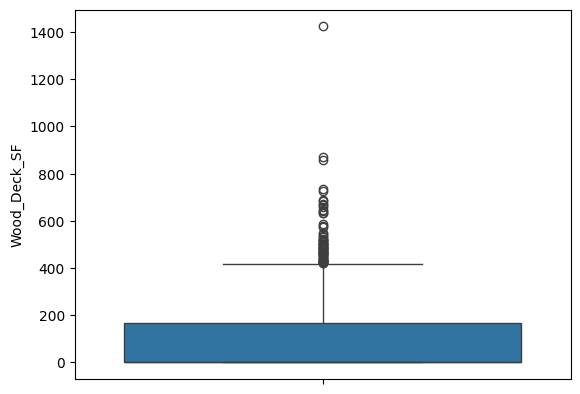

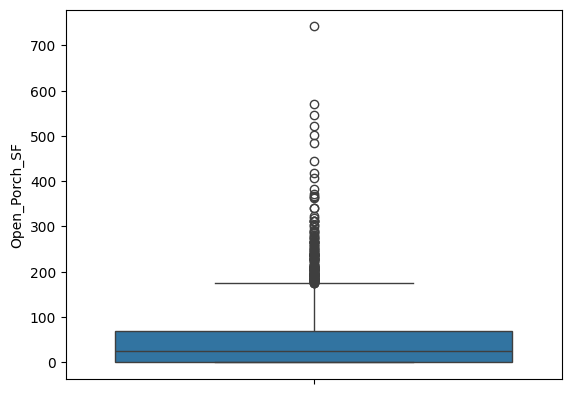

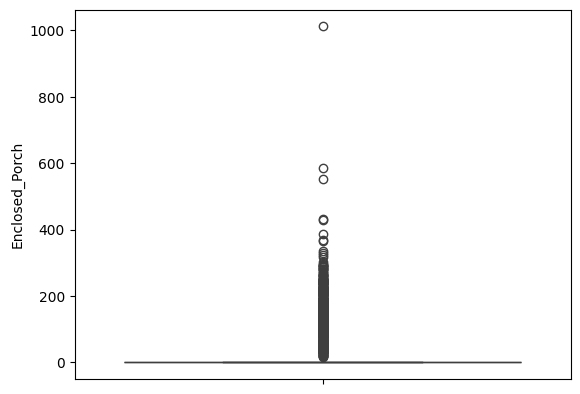

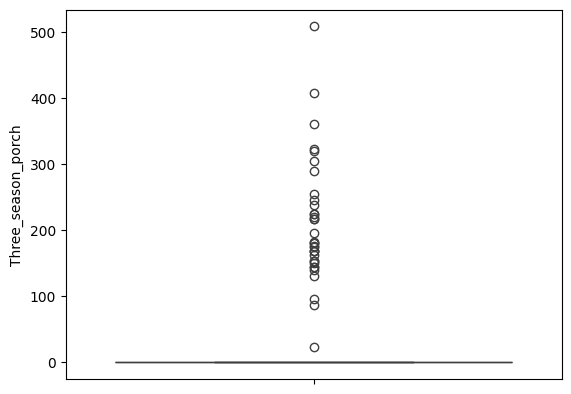

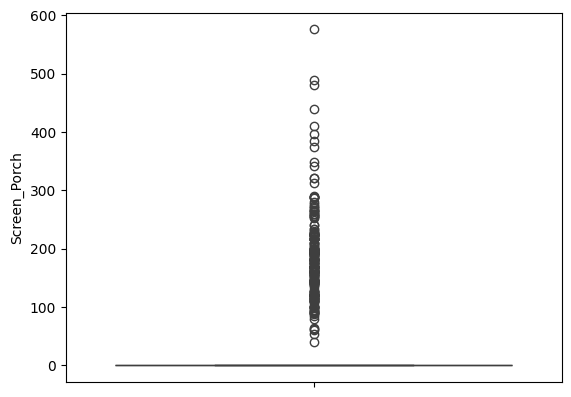

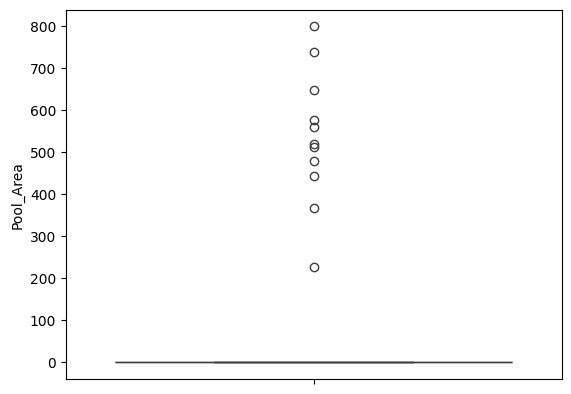

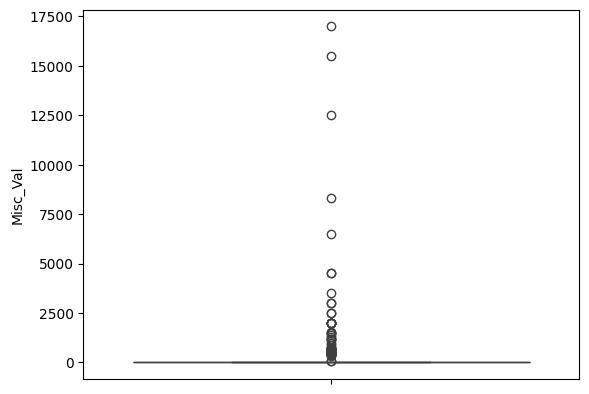

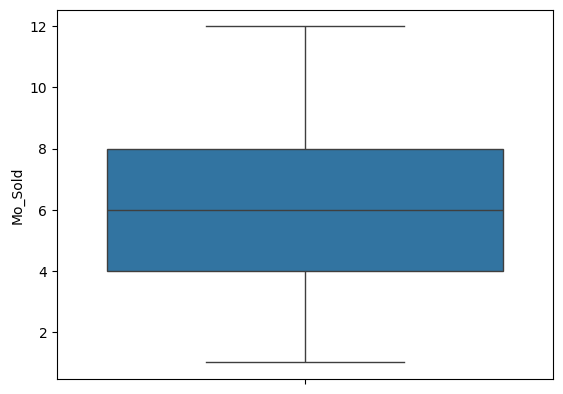

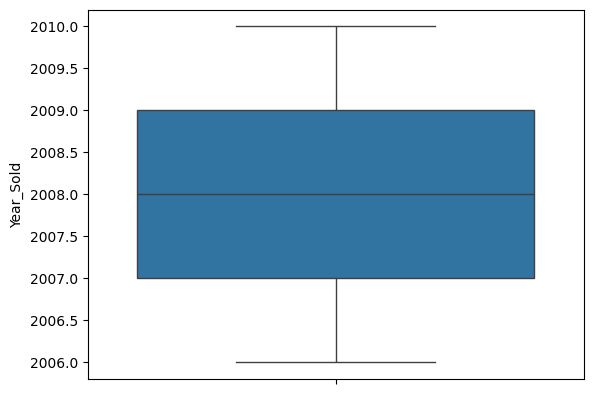

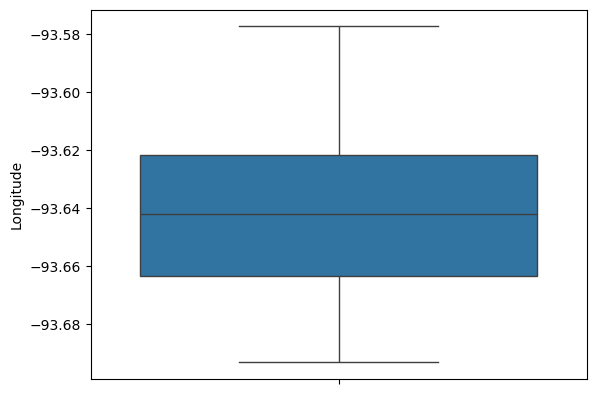

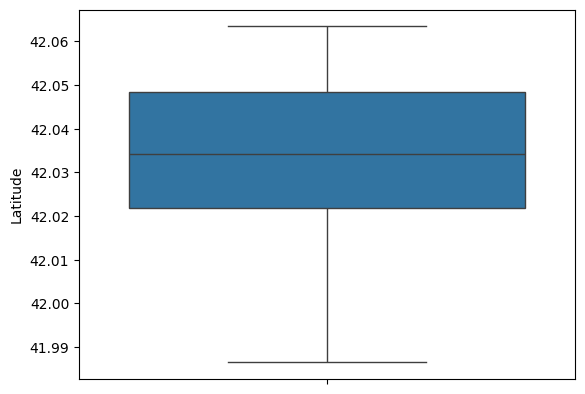

In [ ]:
for col in X.select_dtypes(include=[np.float64]).columns:
  sns.boxplot(X[col])
  plt.show()

In [ ]:
CatColumns = X.select_dtypes(exclude=[np.float64]).columns
NumColumns = X.select_dtypes(include=[np.float64]).columns

RobustColumnTrans = ColumnTransformer([('Categorical',CategoricalPipeline,CatColumns),
                                 ('Numerical',RobustNumericalPipeline,NumColumns)
                                  ])

StandardColumnTrans = ColumnTransformer([('Categorical',CategoricalPipeline,CatColumns),
                                 ('Numerical',StandardNumericalPipeline,NumColumns)
                                  ])

MinMaxColumnTrans = ColumnTransformer([('Categorical',CategoricalPipeline,CatColumns),
                                 ('Numerical',MinMaxNumericalPipeline,NumColumns)
                                  ])

In [ ]:
RobustX = RobustColumnTrans.fit_transform(X)

StandardX = StandardColumnTrans.fit_transform(X)

MinMaxX = MinMaxColumnTrans.fit_transform(X)

y_temp = np.where((y==0)|(y==1), y^1, y)

dic = {"MinMaxScaling":MinMaxX,"StandardScaling":StandardX,"RobustScaler":RobustX}

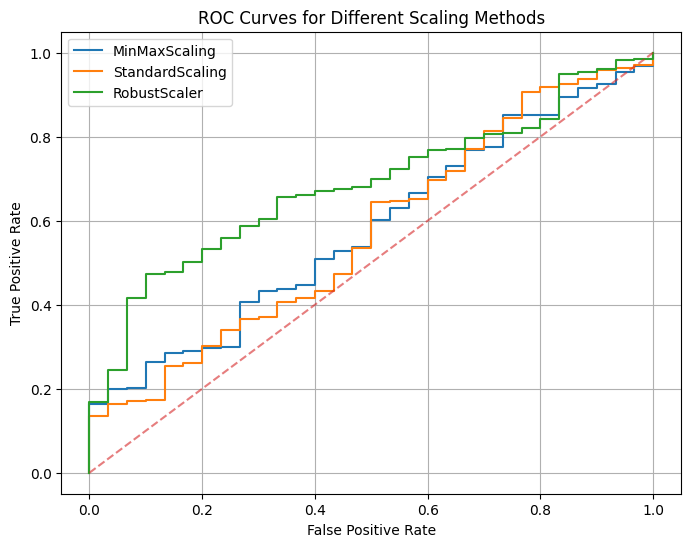

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    IsolationForestEstimator = IsolationForest()

    lof_preds = IsolationForestEstimator.fit_predict(CT)

    IF_y_Scores = IsolationForestEstimator.decision_function(CT)

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods")
plt.legend()
plt.grid(True)
plt.show()

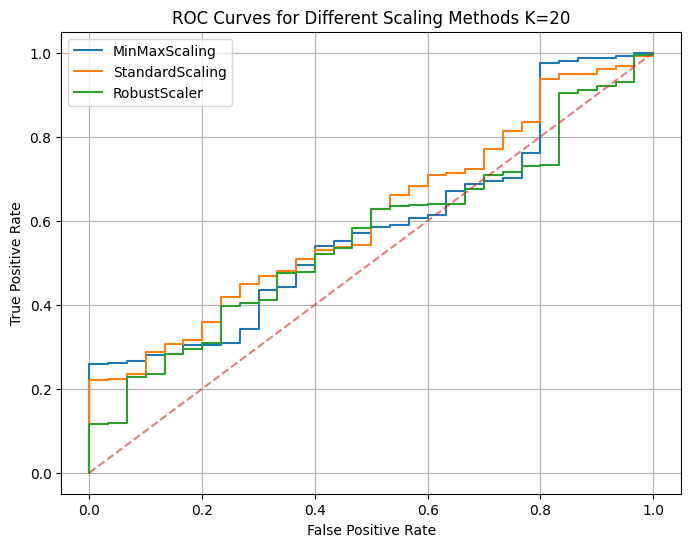

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=20)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=20")
plt.legend()
plt.grid(True)
plt.show()

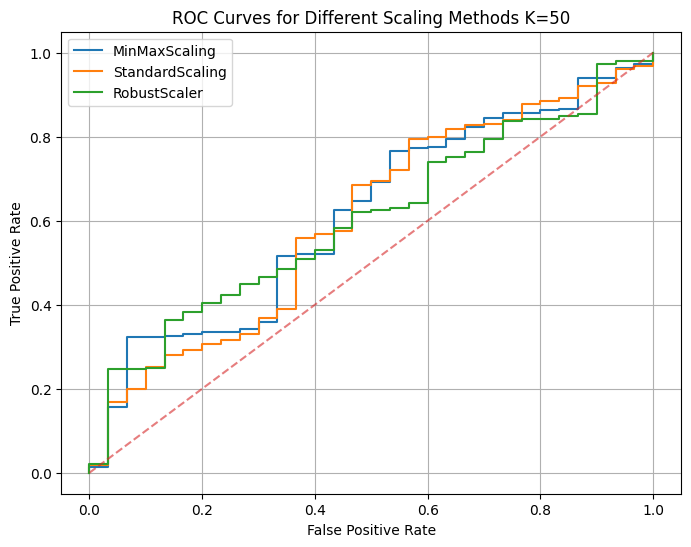

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=50)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=50")
plt.legend()
plt.grid(True)
plt.show()

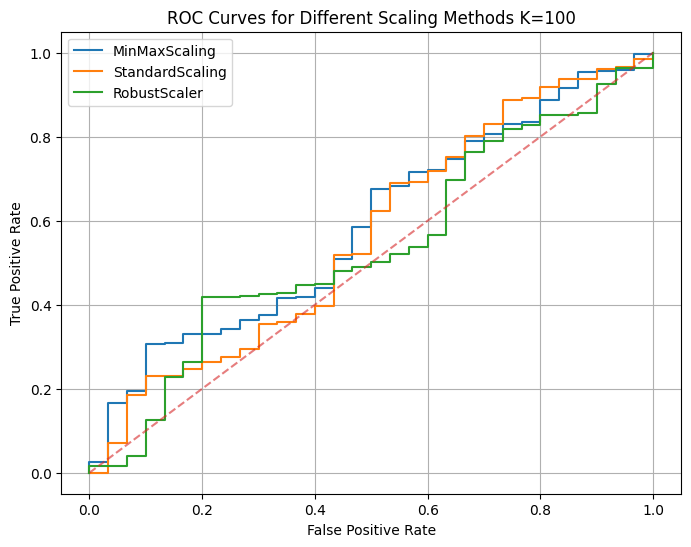

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=100)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=100")
plt.legend()
plt.grid(True)
plt.show()

The dataset contains 46 categorical features. In this case it is easier use a
:class:`~sklearn.compose.make_column_selector` to find them instead of passing
a list made by hand.



### Cardiotocography dataset

The [Cardiotocography dataset](http://www.openml.org/d/1466) is a multiclass
dataset of fetal cardiotocograms, the classes being the fetal heart rate (FHR)
pattern encoded with labels from 1 to 10. Here we set class 3 (the minority
class) to represent the outliers. It contains 30 numerical features, some of
which are binary encoded and some are continuous.



In [ ]:
X, y = fetch_openml(name="cardiotocography", version=1, return_X_y=True, as_frame=False)
X_cardiotocography = X  # save X for later use
s = y == "3"
y = s.astype(np.int32)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

2126 datapoints with 53 anomalies (2.49%)


In [ ]:
print(X.shape)

(2126, 35)


In [ ]:
Robust = RobustScaler()
RobustX = Robust.fit_transform(X)

Standard = StandardScaler()
StandardX = Standard.fit_transform(X)

MinMax = MinMaxScaler()
MinMaxX = MinMax.fit_transform(X)

y_temp = np.where((y==0)|(y==1), y^1, y)

dic = {"MinMaxScaling":MinMaxX,"StandardScaling":StandardX,"RobustScaler":RobustX}

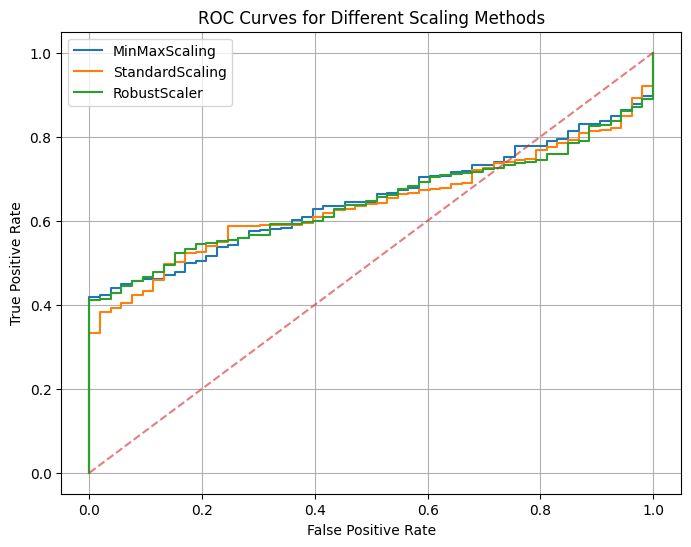

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    IsolationForestEstimator = IsolationForest()

    lof_preds = IsolationForestEstimator.fit_predict(CT)

    IF_y_Scores = IsolationForestEstimator.decision_function(CT)

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods")
plt.legend()
plt.grid(True)
plt.show()

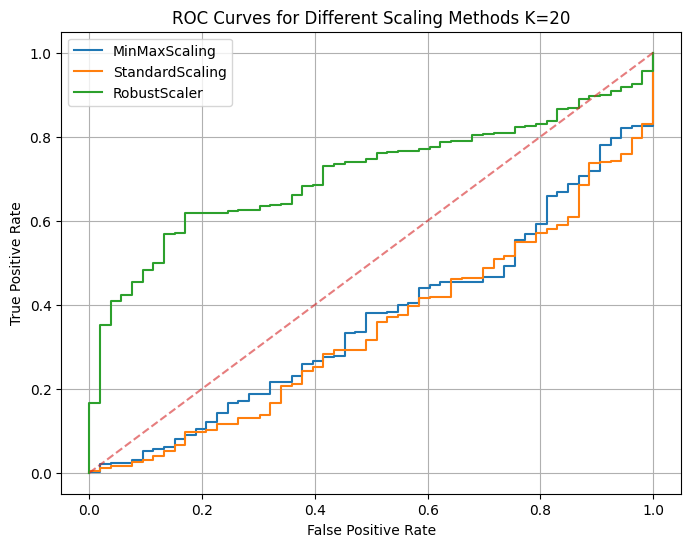

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=20)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=20")
plt.legend()
plt.grid(True)
plt.show()

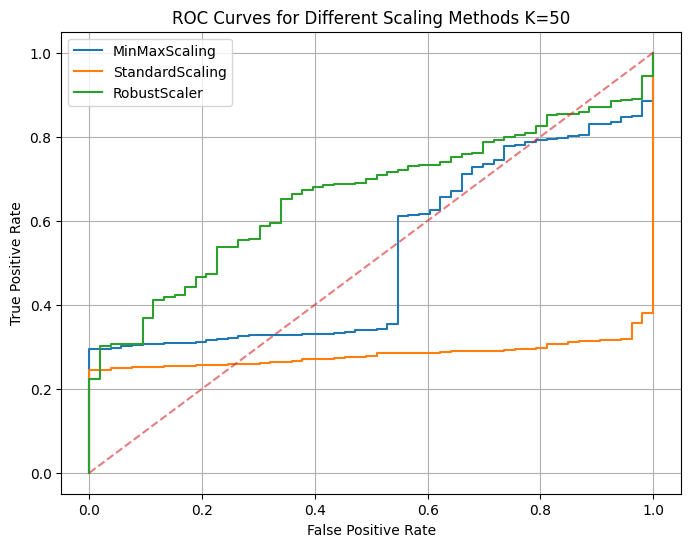

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=50)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=50")
plt.legend()
plt.grid(True)
plt.show()

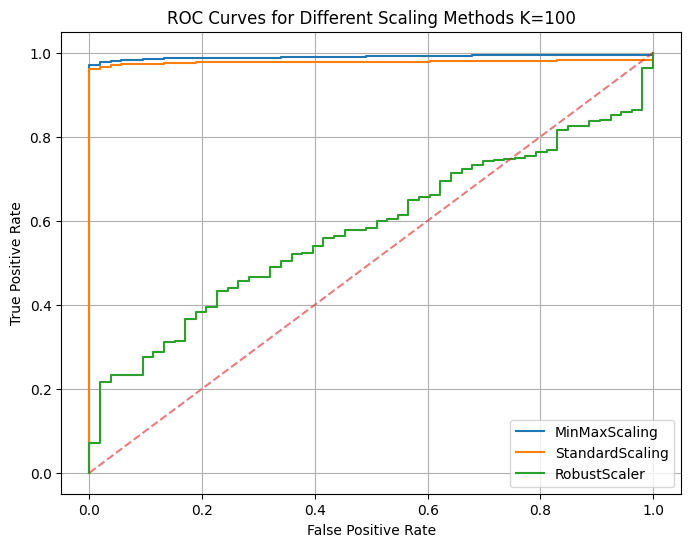

In [ ]:
plt.figure(figsize=(8, 6))

for name, CT in dic.items():

    LocalOutlierFactorEstimator = LocalOutlierFactor(n_neighbors=100)

    lof_preds = LocalOutlierFactorEstimator.fit_predict(CT)

    IF_y_Scores = LocalOutlierFactorEstimator.negative_outlier_factor_

    fpr, tpr, _ = metrics.roc_curve(y_temp, IF_y_Scores)

    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Scaling Methods K=100")
plt.legend()
plt.grid(True)
plt.show()